In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from functools import reduce
from tqdm import tqdm


2023-12-23 21:22:47.627183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 21:22:47.878742: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-23 21:22:48.006939: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 21:22:48.901590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

#### 데이터 준비

In [2]:
CNBC = pd.read_csv("/home/user/exercise_j/GPT Project/AutoDataModify/test/CNBCTESTFinal_classified.csv")
SA = pd.read_csv("/home/user/exercise_j/GPT Project/AutoDataModify/test/SATESTFinal_classified.csv")

In [3]:
CNBC.dropna(subset=['date', 'ticker', 'sentiment_score'], inplace=True)
SA.dropna(subset=['date', 'ticker', 'sentiment_score'], inplace=True)

In [4]:
CNBC['date'] = pd.to_datetime(CNBC['date'])
SA['date'] = pd.to_datetime(SA['date'])

CNBC.sort_values(by='date', ascending=True, inplace=True)
SA.sort_values(by='date', ascending=True, inplace=True)

In [5]:
CNBC.reset_index(drop=True, inplace=True)
SA.reset_index(drop=True, inplace=True)

In [6]:
del CNBC['ticker']
del SA['ticker']

In [7]:
# 2106년과 2006년 데이터 필터링
SA['date'] = pd.to_datetime(SA['date'])
SA = SA[(SA['date'].dt.year != 2106) & (SA['date'].dt.year != 2024) &  ~((SA['date'].dt.year == 2023) & (SA['date'].dt.month == 12)) & (SA['date'].dt.year != 2008) & (SA['date'].dt.year != 2006) & (SA['date'].dt.year != 2007) & (SA['date'].dt.year != 2008)]

#### Seeking Alpha(SA)와 CNBC 데이터셋을 병합하여 입력 데이터셋을 구성합니다.

In [8]:
# 두 데이터프레임을 합치기
combined_df = pd.concat([CNBC, SA], ignore_index=True)

print(combined_df.head())

                                             Content       date  \
0  Ash Bennington   11/30/2010 3:13:56 AMFA PLAYB... 2010-11-30   
1  John Carney   6/21/2011 5:51:34 AMInvestors ur... 2011-06-21   
2  Matt Clinch   7/8/2013 3:10:37 PMCritics Unfri... 2013-07-08   
3  Seema Mody   7/9/2013 3:29:01 AMBitcoin ETF pl... 2013-07-09   
4  Arash Massoudi and Tracy Alloway   7/16/2013 8... 2013-07-16   

   sentiment_score content  
0              0.5     NaN  
1              0.5     NaN  
2              0.5     NaN  
3              0.2     NaN  
4              0.7     NaN  


In [9]:
combined_df_sum = combined_df.groupby('date')['sentiment_score'].sum().reset_index()
print(combined_df_sum)

           date  sentiment_score
0    2010-08-08              0.2
1    2010-11-30              0.5
2    2011-01-07              0.6
3    2011-06-21              0.5
4    2012-12-17              0.7
...         ...              ...
2018 2023-11-16              0.5
2019 2023-11-17              0.2
2020 2023-11-20              2.0
2021 2023-11-21              0.6
2022 2023-11-23              0.7

[2023 rows x 2 columns]


##### 2023년 11월 23일에 'crypto' 카테고리의 호재인 뉴스가 많았음을 추측해볼 수 있습니다.

In [10]:
combined_df_sum.max()

date               2023-11-23 00:00:00
sentiment_score                   26.5
dtype: object

#### BTC 거래 종가, 거래 규모 데이터 (2010.11.30 ~ 2023.11.30)

In [11]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BTC_historical_dataset.csv")

In [12]:
del BTC['변동 %']
del BTC['고가']
del BTC['시가']
del BTC['저가']
BTC.tail()

,날짜,종가,거래량
4744,2010- 12- 04,0.2,28.56K
4745,2010- 12- 03,0.3,2.57K
4746,2010- 12- 02,0.3,20.31K
4747,2010- 12- 01,0.2,8.16K
4748,2010- 11- 30,0.2,21.48K


#### (${p_t}, {v_t}, {s_t}$) 만들기

In [13]:
combined_df_sum['date'] = pd.to_datetime(combined_df_sum['date'])
BTC['date'] = pd.to_datetime(BTC['날짜'])
del BTC['날짜']

In [14]:
df_merged = pd.merge(BTC, combined_df_sum, on='date', how='outer')

# 결과 확인
print(df_merged)

            종가     거래량       date  sentiment_score
0     37,712.9  33.53K 2023-11-30              NaN
1     37,855.5  49.34K 2023-11-29              NaN
2     37,823.3  57.50K 2023-11-28              NaN
3     37,248.6  45.24K 2023-11-27              NaN
4     37,451.8  29.20K 2023-11-26              NaN
...        ...     ...        ...              ...
4745       0.3   2.57K 2010-12-03              NaN
4746       0.3  20.31K 2010-12-02              NaN
4747       0.2   8.16K 2010-12-01              NaN
4748       0.2  21.48K 2010-11-30              0.5
4749       NaN     NaN 2010-08-08              0.2

[4750 rows x 4 columns]


#### 'sentiment_score'의 NaN 값은 뉴스가 없는 상태로 0.5(중립)으로 치환

In [15]:
df_merged['sentiment_score'].fillna(0.5, inplace=True)

# 결과 확인
print(df_merged.head())

         종가     거래량       date  sentiment_score
0  37,712.9  33.53K 2023-11-30              0.5
1  37,855.5  49.34K 2023-11-29              0.5
2  37,823.3  57.50K 2023-11-28              0.5
3  37,248.6  45.24K 2023-11-27              0.5
4  37,451.8  29.20K 2023-11-26              0.5


#### 결측치 제거 및 확인

In [16]:
df_merged.dropna(inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.isna().sum()

종가                 0
거래량                0
date               0
sentiment_score    0
dtype: int64

#### BTC 거래량 데이터 변환

In [17]:
def convert_volume(volume):
    if isinstance(volume, str):  # volume이 문자열인지 확인
        if 'K' in volume:
            return float(volume.replace('K', '')) * 1000
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1000000
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1000000000
        else:
            return float(volume)
    else:
        return volume

df_merged['거래량'] = df_merged['거래량'].apply(convert_volume)


In [18]:
# NumPy 배열로 변환
prices = df_merged['종가'].values.reshape(-1, 1)
float_arr = np.array([float(x[0].replace(',', '')) for x in prices])
float_arr_2d = float_arr.reshape(-1, 1)
volumes = df_merged['거래량'].values.reshape(-1, 1)
sentiments = df_merged['sentiment_score'].values.reshape(-1, 1)

# NumPy 배열을 (p_t, v_t, s_t) 꼴로 결합
data = np.hstack((float_arr_2d, volumes, sentiments))

# 결과 확인
print(data)

[[3.77129e+04 3.35300e+04 5.00000e-01]
 [3.78555e+04 4.93400e+04 5.00000e-01]
 [3.78233e+04 5.75000e+04 5.00000e-01]
 ...
 [3.00000e-01 2.03100e+04 5.00000e-01]
 [2.00000e-01 8.16000e+03 5.00000e-01]
 [2.00000e-01 2.14800e+04 5.00000e-01]]


#### 표준화(스케일링)

In [19]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 데이터를 표준화
data = scaler.fit_transform(data)

#### 데이터셋 산포도(scatter plot) 확인

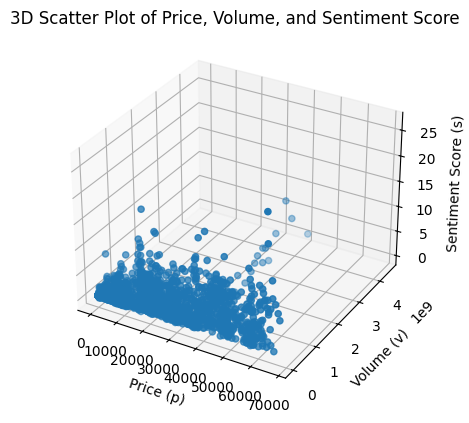

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# 3D 산점도 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 축에 데이터 플롯
ax.scatter(float_arr_2d, volumes, sentiments)

# 축 레이블 설정
ax.set_xlabel('Price (p)')
ax.set_ylabel('Volume (v)')
ax.set_zlabel('Sentiment Score (s)')

# 그래프 제목 설정
ax.set_title('3D Scatter Plot of Price, Volume, and Sentiment Score')

# 그래프 보여주기
plt.show()


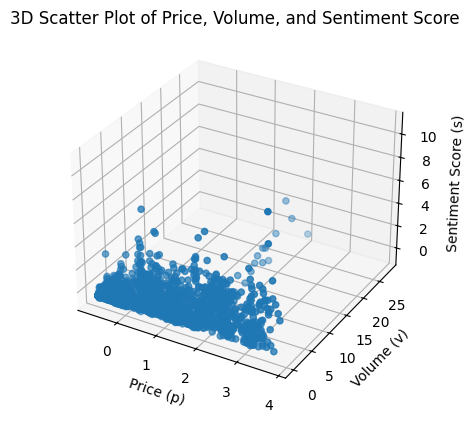

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

float_arr_2d = scaler.fit_transform(float_arr_2d)
volumes = scaler.fit_transform(volumes)
sentiments = scaler.fit_transform(sentiments)

# 각 축에 데이터 플롯
ax.scatter(float_arr_2d, volumes, sentiments)

# 축 레이블 설정
ax.set_xlabel('Price (p)')
ax.set_ylabel('Volume (v)')
ax.set_zlabel('Sentiment Score (s)')

# 그래프 제목 설정
ax.set_title('3D Scatter Plot of Price, Volume, and Sentiment Score')

# 그래프 보여주기
plt.show()


#### GPU 설정 확인 및 조정

In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [23]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

# 모든 GPU에 대해 메모리 성장 설정 적용
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


#### LSTM 모델 설정

In [32]:
### LSTM 모델 불러오기
input_data = np.reshape(data, (1, 1, -1))
input_size = 4
lstm_units = 50 # 초기 셀의 개수 설정

def initialize_ecm_lstm(input_size, lstm_units):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(None, input_size)))
    model.add(Dense(1))  # 예측할 값이 1차원 (예: 수익률)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = initialize_ecm_lstm(input_size, lstm_units)

### **ECM-LSTM 알고리즘**

In [25]:
initial_centroid = data[0]
centroids = [initial_centroid]
radiuses = [0]

def convert_to_float(arr):
    return np.array([float(str(val).replace(',', '')) if isinstance(val, str) else val for val in arr])

# 모든 데이터를 문자열 => 숫자로 변환
data = np.array([convert_to_float(row) for row in data])
centroids = [convert_to_float(c) for c in centroids]

### ECM-LSTM 알고리즘

def ecm_lstm_algorithm(data, centroids, radiuses, model):
    predicted_returns = []

    for t in tqdm(range(len(data)), desc="Processing"):
        new_data = data[t]
        closest_idx = None
        min_distance = float('inf')

        # 가장 가까운 클러스터 찾기
        for idx, c in enumerate(centroids):
            distance = np.linalg.norm(new_data - c)
            if distance < min_distance:
                min_distance = distance
                closest_idx = idx

        # 클러스터 업데이트
        if closest_idx is not None and min_distance <= radiuses[closest_idx]:
            centroids[closest_idx] = (centroids[closest_idx] + new_data) / 2
            radiuses[closest_idx] = max(radiuses[closest_idx], min_distance)
        else:
            # 새 클러스터 추가 또는 기존 클러스터 업데이트
            # 새 데이터가 모든 클러스터의 반경 밖에 있는 경우
            if all(min_distance > 2 * r for r in radiuses):
                centroids.append(new_data)
                radiuses.append(min_distance)
            else:
                # 가장 가까운 클러스터 업데이트
                centroids[closest_idx] = (centroids[closest_idx] + new_data) / 2
                radiuses[closest_idx] = max(radiuses[closest_idx], min_distance)

        # LSTM 모델을 사용한 예측
        # new_data와 min_distance를 결합하여 LSTM 입력 데이터 생성
        # lstm_input_data = np.hstack((new_data, min_distance))

        # LSTM 모델에 입력 데이터 전달 및 예측 수행
        predicted_return = model.predict(np.reshape(new_data, (1, 1, -1)))
        predicted_returns.append(predicted_return.tolist())
        print(predicted_return)
    return centroids, radiuses, predicted_returns

In [33]:
from tqdm import tqdm
import numpy as np

def ecm_lstm_algorithm2(data, centroids, radiuses, model):
    predicted_returns = []

    # 데이터 처리 루프
    for t in tqdm(range(len(data)), desc="Processing"):
        new_data = data[t]
        closest_idx = None
        D_min = float('inf')
        S_min_i = float('inf')

        # D_min 계산: 가장 가까운 클러스터 찾기
        for idx, c in enumerate(centroids):
            distance = np.linalg.norm(new_data - c)
            if distance < D_min:
                D_min = distance
                closest_idx = idx

        # S_min,i 계산
        for idx, (c, r) in enumerate(zip(centroids, radiuses)):
            S_min = np.linalg.norm(new_data - c) + r
            if S_min < S_min_i:
                S_min_i = S_min
                closest_idx = idx

        # 클러스터 업데이트
        if closest_idx is not None and D_min <= radiuses[closest_idx]:
            centroids[closest_idx] = (centroids[closest_idx] + new_data) / 2
            radiuses[closest_idx] = max(radiuses[closest_idx], D_min)
        else:
            # 새 클러스터 추가 또는 기존 클러스터 업데이트
            if S_min_i > 2 * radiuses[closest_idx]:
                centroids.append(new_data)
                radiuses.append(D_min)
            else:
                centroids[closest_idx] = (centroids[closest_idx] + new_data) / 2
                radiuses[closest_idx] = max(radiuses[closest_idx], D_min)

        # LSTM 모델을 사용한 예측
        lstm_input_data = np.hstack((new_data, D_min))
        predicted_return = model.predict(np.reshape(lstm_input_data, (1, 1, -1)))
        predicted_returns.append(predicted_return.tolist())

    return centroids, radiuses, predicted_returns


In [28]:
def convert_to_float(arr):
    return np.array([float(str(val).replace(',', '')) if isinstance(val, str) else val for val in arr])

# 모든 데이터를 문자열 => 숫자로 변환
data = np.array([convert_to_float(row) for row in data])    

def ecm_lstm_algorithm2(data, centroids, radiuses, model):
    predicted_returns = []
    centroids = []
    radiuses = []
    
    if centroids == None :
        centroids.append(data[0])
        radiuses.append(0)
        
        predicted_return = model.predict(np.reshape(data, (1, 1, -1)))
        predicted_returns.append(predicted_return.tolist())
        print(predicted_return)
    else :
        t = 1
        for t in tqdm(range(len(data)+1), desc="Processing"):
            # new_data = data[t]
            closest_idx = None
            min_distance = float('inf')
            min_distance2 = float('inf')

            # D_min 구하기
            for idx, c in enumerate(centroids):
                distance = np.linalg.norm(data - c)
                if distance < min_distance:
                    min_distance = distance
                    closest_idx = idx   # i 를 가리킴   

            if closest_idx is not None and min_distance <= radiuses[closest_idx]:
                centroids[closest_idx].append(data[t])

                predicted_return = model.predict(np.reshape(data, (1, 1, -1)))
                predicted_returns.append(predicted_return.tolist())
                print(predicted_return)  

            else : 
                # S(min,i) 구하기
                for idx, c, r in enumerate(zip(centroids,radiuses)):
                    distance2 = np.linalg.norm(data - c) + r
                    if distance2 < min_distance2:
                        min_distance2 = distance2
                        closest_idx = idx   # i 를 가리킴

                if closest_idx is not None and min_distance2 > 2*radiuses[closest_idx]:
                    centroids.append(data[t])

                    predicted_return = model.predict(np.reshape(data, (1, 1, -1)))
                    predicted_returns.append(predicted_return.tolist())
                    print(predicted_return)  
                
                else : 
                    centroids[closest_idx].append(data[t])
                    centroids[closest_idx] = (centroids[closest_idx] + data) / 2
                    radiuses[closest_idx] = max(radiuses[closest_idx], min_distance2)

                    predicted_return = model.predict(np.reshape(data, (1, 1, -1)))
                    predicted_returns.append(predicted_return.tolist())
                    print(predicted_return)  

    return centroids, radiuses, predicted_returns




In [34]:
centroids, radiuses, predicted_returns = ecm_lstm_algorithm2(data, centroids, radiuses, model)

Processing:   0%|          | 0/4743 [00:00<?, ?it/s]2023-12-23 22:48:36.547330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step


Processing:   0%|          | 1/4743 [00:02<2:41:24,  2.04s/it]

1/1 [==============================] - 0s 17ms/step


Processing:   0%|          | 3/4743 [00:02<45:18,  1.74it/s]  

1/1 [==============================] - 0s 18ms/step


Processing:   0%|          | 6/4743 [00:02<19:53,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   0%|          | 8/4743 [00:02<14:14,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


Processing:   0%|          | 10/4743 [00:02<11:29,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


Processing:   0%|          | 12/4743 [00:02<09:20,  8.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   0%|          | 14/4743 [00:02<07:45, 10.15it/s]

1/1 [==============================] - 0s 27ms/step


Processing:   0%|          | 16/4743 [00:02<06:55, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   0%|          | 18/4743 [00:03<06:00, 13.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   0%|          | 21/4743 [00:03<04:51, 16.20it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   0%|          | 23/4743 [00:03<04:36, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 26/4743 [00:03<04:02, 19.45it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 29/4743 [00:03<03:46, 20.85it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   1%|          | 32/4743 [00:03<03:55, 20.03it/s]

1/1 [==============================] - 0s 29ms/step


Processing:   1%|          | 35/4743 [00:03<04:04, 19.28it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 38/4743 [00:03<04:03, 19.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 41/4743 [00:04<03:52, 20.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 44/4743 [00:04<04:00, 19.57it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 47/4743 [00:04<03:54, 20.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 50/4743 [00:04<03:47, 20.61it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   1%|          | 53/4743 [00:04<03:57, 19.75it/s]

1/1 [==============================] - 0s 29ms/step


Processing:   1%|          | 56/4743 [00:04<04:17, 18.18it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|          | 59/4743 [00:05<04:05, 19.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|▏         | 61/4743 [00:05<04:07, 18.89it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|▏         | 63/4743 [00:05<04:10, 18.68it/s]

1/1 [==============================] - 0s 31ms/step


Processing:   1%|▏         | 66/4743 [00:05<04:09, 18.77it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   1%|▏         | 68/4743 [00:05<04:10, 18.67it/s]

1/1 [==============================] - 0s 22ms/step


Processing:   1%|▏         | 70/4743 [00:05<04:13, 18.46it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 72/4743 [00:05<04:10, 18.62it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   2%|▏         | 75/4743 [00:05<04:06, 18.91it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   2%|▏         | 77/4743 [00:06<04:09, 18.73it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 80/4743 [00:06<03:48, 20.38it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   2%|▏         | 83/4743 [00:06<03:46, 20.58it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 86/4743 [00:06<03:53, 19.95it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 89/4743 [00:06<03:39, 21.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 92/4743 [00:06<03:50, 20.17it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 95/4743 [00:06<03:46, 20.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 98/4743 [00:07<03:41, 20.95it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   2%|▏         | 101/4743 [00:07<03:41, 20.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 104/4743 [00:07<03:45, 20.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 107/4743 [00:07<03:56, 19.59it/s]

1/1 [==============================] - 0s 27ms/step


Processing:   2%|▏         | 109/4743 [00:07<04:00, 19.29it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 112/4743 [00:07<03:47, 20.36it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 115/4743 [00:07<03:33, 21.68it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   2%|▏         | 118/4743 [00:07<03:25, 22.51it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   3%|▎         | 121/4743 [00:08<03:55, 19.65it/s]

1/1 [==============================] - 0s 29ms/step


Processing:   3%|▎         | 124/4743 [00:08<03:55, 19.64it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   3%|▎         | 127/4743 [00:08<03:57, 19.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   3%|▎         | 130/4743 [00:08<04:01, 19.14it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   3%|▎         | 133/4743 [00:08<03:53, 19.71it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   3%|▎         | 136/4743 [00:08<03:37, 21.14it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   3%|▎         | 139/4743 [00:09<03:58, 19.29it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   3%|▎         | 141/4743 [00:09<03:59, 19.24it/s]

1/1 [==============================] - 0s 26ms/step


Processing:   3%|▎         | 143/4743 [00:09<04:22, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   3%|▎         | 146/4743 [00:09<04:11, 18.31it/s]

1/1 [==============================] - 0s 30ms/step


Processing:   3%|▎         | 148/4743 [00:09<04:31, 16.91it/s]

1/1 [==============================] - 0s 27ms/step


Processing:   3%|▎         | 150/4743 [00:09<04:28, 17.08it/s]

1/1 [==============================] - 0s 31ms/step


Processing:   3%|▎         | 152/4743 [00:09<04:36, 16.60it/s]

1/1 [==============================] - 0s 28ms/step


Processing:   3%|▎         | 155/4743 [00:10<04:19, 17.69it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   3%|▎         | 158/4743 [00:10<04:00, 19.03it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   3%|▎         | 161/4743 [00:10<03:50, 19.88it/s]

1/1 [==============================] - 0s 26ms/step


Processing:   3%|▎         | 164/4743 [00:10<03:55, 19.46it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   3%|▎         | 166/4743 [00:10<04:06, 18.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   4%|▎         | 168/4743 [00:10<04:03, 18.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   4%|▎         | 170/4743 [00:10<04:05, 18.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   4%|▎         | 173/4743 [00:10<03:51, 19.75it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   4%|▎         | 175/4743 [00:11<04:00, 18.96it/s]

1/1 [==============================] - 0s 31ms/step


Processing:   4%|▎         | 177/4743 [00:11<04:03, 18.72it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   4%|▍         | 179/4743 [00:11<04:12, 18.10it/s]

1/1 [==============================] - 0s 23ms/step


Processing:   4%|▍         | 181/4743 [00:11<04:15, 17.84it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   4%|▍         | 184/4743 [00:11<03:58, 19.15it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   4%|▍         | 187/4743 [00:11<03:55, 19.32it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   4%|▍         | 189/4743 [00:11<04:05, 18.56it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   4%|▍         | 191/4743 [00:11<04:06, 18.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   4%|▍         | 193/4743 [00:12<04:06, 18.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   4%|▍         | 195/4743 [00:12<04:14, 17.86it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   4%|▍         | 197/4743 [00:12<04:44, 16.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   4%|▍         | 199/4743 [00:12<04:45, 15.91it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   4%|▍         | 202/4743 [00:12<04:16, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   4%|▍         | 204/4743 [00:12<04:13, 17.93it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   4%|▍         | 206/4743 [00:12<04:20, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   4%|▍         | 209/4743 [00:12<04:01, 18.79it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   4%|▍         | 211/4743 [00:13<04:12, 17.95it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   4%|▍         | 213/4743 [00:13<04:13, 17.86it/s]

1/1 [==============================] - 0s 26ms/step


Processing:   5%|▍         | 215/4743 [00:13<04:12, 17.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   5%|▍         | 218/4743 [00:13<03:58, 18.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   5%|▍         | 221/4743 [00:13<03:37, 20.83it/s]

1/1 [==============================] - 0s 21ms/step


Processing:   5%|▍         | 224/4743 [00:13<03:28, 21.72it/s]

1/1 [==============================] - 0s 15ms/step


Processing:   5%|▍         | 227/4743 [00:13<03:23, 22.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   5%|▍         | 230/4743 [00:13<03:29, 21.50it/s]

1/1 [==============================] - 0s 30ms/step


Processing:   5%|▍         | 233/4743 [00:14<03:58, 18.92it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   5%|▍         | 235/4743 [00:14<04:03, 18.51it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   5%|▍         | 237/4743 [00:14<04:18, 17.40it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   5%|▌         | 239/4743 [00:14<04:20, 17.31it/s]

1/1 [==============================] - 0s 15ms/step


Processing:   5%|▌         | 242/4743 [00:14<03:52, 19.36it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   5%|▌         | 244/4743 [00:14<03:59, 18.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   5%|▌         | 247/4743 [00:14<03:55, 19.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   5%|▌         | 250/4743 [00:15<03:35, 20.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   5%|▌         | 253/4743 [00:15<03:42, 20.21it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   5%|▌         | 256/4743 [00:15<03:29, 21.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   5%|▌         | 259/4743 [00:15<03:27, 21.57it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   6%|▌         | 262/4743 [00:15<03:47, 19.73it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   6%|▌         | 265/4743 [00:15<03:39, 20.43it/s]

1/1 [==============================] - 0s 30ms/step


Processing:   6%|▌         | 268/4743 [00:15<03:50, 19.44it/s]

1/1 [==============================] - 0s 29ms/step


Processing:   6%|▌         | 270/4743 [00:16<04:03, 18.38it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   6%|▌         | 273/4743 [00:16<03:45, 19.80it/s]

1/1 [==============================] - 0s 30ms/step


Processing:   6%|▌         | 276/4743 [00:16<04:00, 18.58it/s]

1/1 [==============================] - 0s 31ms/step


Processing:   6%|▌         | 278/4743 [00:16<04:13, 17.63it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   6%|▌         | 280/4743 [00:16<04:12, 17.67it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   6%|▌         | 282/4743 [00:16<04:11, 17.72it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   6%|▌         | 284/4743 [00:16<04:05, 18.17it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   6%|▌         | 286/4743 [00:16<04:11, 17.74it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   6%|▌         | 288/4743 [00:17<04:15, 17.44it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   6%|▌         | 291/4743 [00:17<03:58, 18.64it/s]

1/1 [==============================] - 0s 15ms/step


Processing:   6%|▌         | 294/4743 [00:17<03:41, 20.10it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   6%|▋         | 297/4743 [00:17<03:47, 19.59it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   6%|▋         | 300/4743 [00:17<03:42, 20.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   6%|▋         | 303/4743 [00:17<03:27, 21.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   6%|▋         | 306/4743 [00:17<03:24, 21.67it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   7%|▋         | 309/4743 [00:18<03:33, 20.74it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   7%|▋         | 312/4743 [00:18<03:24, 21.62it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 315/4743 [00:18<03:42, 19.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 318/4743 [00:18<03:29, 21.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 321/4743 [00:18<03:35, 20.56it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 324/4743 [00:18<03:37, 20.34it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 327/4743 [00:18<03:44, 19.68it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   7%|▋         | 329/4743 [00:19<03:57, 18.59it/s]

1/1 [==============================] - 0s 27ms/step


Processing:   7%|▋         | 331/4743 [00:19<04:08, 17.77it/s]

1/1 [==============================] - 0s 29ms/step


Processing:   7%|▋         | 333/4743 [00:19<04:12, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 335/4743 [00:19<04:10, 17.61it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   7%|▋         | 337/4743 [00:19<04:13, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 339/4743 [00:19<04:05, 17.93it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   7%|▋         | 341/4743 [00:19<04:09, 17.67it/s]

1/1 [==============================] - 0s 23ms/step


Processing:   7%|▋         | 344/4743 [00:19<03:57, 18.53it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   7%|▋         | 347/4743 [00:20<03:56, 18.58it/s]

1/1 [==============================] - 0s 32ms/step


Processing:   7%|▋         | 350/4743 [00:20<04:03, 18.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   7%|▋         | 353/4743 [00:20<03:50, 19.05it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 356/4743 [00:20<03:47, 19.26it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 358/4743 [00:20<03:58, 18.38it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   8%|▊         | 361/4743 [00:20<03:44, 19.50it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 363/4743 [00:20<03:55, 18.64it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   8%|▊         | 365/4743 [00:21<04:05, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   8%|▊         | 368/4743 [00:21<03:50, 18.98it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 371/4743 [00:21<03:40, 19.80it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   8%|▊         | 373/4743 [00:21<03:48, 19.12it/s]

1/1 [==============================] - 0s 24ms/step


Processing:   8%|▊         | 375/4743 [00:21<04:07, 17.62it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   8%|▊         | 377/4743 [00:21<04:09, 17.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   8%|▊         | 379/4743 [00:21<04:08, 17.59it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 381/4743 [00:21<04:06, 17.69it/s]

1/1 [==============================] - 0s 24ms/step


Processing:   8%|▊         | 384/4743 [00:22<04:14, 17.14it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   8%|▊         | 386/4743 [00:22<04:43, 15.38it/s]

1/1 [==============================] - 0s 29ms/step


Processing:   8%|▊         | 388/4743 [00:22<04:38, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 390/4743 [00:22<04:23, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   8%|▊         | 393/4743 [00:22<04:06, 17.68it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 395/4743 [00:22<04:05, 17.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 398/4743 [00:22<03:46, 19.17it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   8%|▊         | 401/4743 [00:23<03:36, 20.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   9%|▊         | 404/4743 [00:23<03:23, 21.27it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   9%|▊         | 407/4743 [00:23<03:20, 21.67it/s]

1/1 [==============================] - 0s 16ms/step


Processing:   9%|▊         | 410/4743 [00:23<03:16, 22.00it/s]

1/1 [==============================] - 0s 21ms/step


Processing:   9%|▊         | 413/4743 [00:23<04:52, 14.79it/s]

1/1 [==============================] - 0s 26ms/step


Processing:   9%|▉         | 416/4743 [00:23<04:39, 15.49it/s]

1/1 [==============================] - 0s 35ms/step


Processing:   9%|▉         | 418/4743 [00:24<04:36, 15.64it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   9%|▉         | 420/4743 [00:24<04:22, 16.48it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   9%|▉         | 422/4743 [00:24<04:26, 16.21it/s]

1/1 [==============================] - 0s 20ms/step


Processing:   9%|▉         | 424/4743 [00:24<04:18, 16.71it/s]

1/1 [==============================] - 0s 21ms/step


Processing:   9%|▉         | 426/4743 [00:24<04:29, 16.02it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   9%|▉         | 428/4743 [00:24<04:19, 16.62it/s]

1/1 [==============================] - 0s 33ms/step


Processing:   9%|▉         | 430/4743 [00:24<04:38, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   9%|▉         | 432/4743 [00:24<04:26, 16.17it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   9%|▉         | 435/4743 [00:25<03:56, 18.20it/s]

1/1 [==============================] - 0s 18ms/step


Processing:   9%|▉         | 437/4743 [00:25<04:03, 17.67it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   9%|▉         | 439/4743 [00:25<04:13, 17.00it/s]

1/1 [==============================] - 0s 19ms/step


Processing:   9%|▉         | 441/4743 [00:25<04:08, 17.34it/s]

1/1 [==============================] - 0s 17ms/step


Processing:   9%|▉         | 444/4743 [00:25<03:43, 19.25it/s]

1/1 [==============================] - 0s 28ms/step


Processing:   9%|▉         | 446/4743 [00:25<03:47, 18.86it/s]

1/1 [==============================] - 0s 22ms/step


Processing:   9%|▉         | 448/4743 [00:25<03:58, 17.97it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  10%|▉         | 451/4743 [00:25<03:51, 18.52it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  10%|▉         | 454/4743 [00:26<03:46, 18.92it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  10%|▉         | 457/4743 [00:26<03:34, 19.99it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  10%|▉         | 460/4743 [00:26<03:30, 20.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  10%|▉         | 463/4743 [00:26<03:19, 21.42it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  10%|▉         | 466/4743 [00:26<03:23, 21.00it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  10%|▉         | 469/4743 [00:26<03:46, 18.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  10%|▉         | 471/4743 [00:26<03:46, 18.83it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  10%|▉         | 473/4743 [00:27<03:53, 18.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  10%|█         | 475/4743 [00:27<03:59, 17.83it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  10%|█         | 477/4743 [00:27<04:15, 16.69it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  10%|█         | 480/4743 [00:27<03:54, 18.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  10%|█         | 482/4743 [00:27<03:54, 18.13it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  10%|█         | 484/4743 [00:27<04:07, 17.23it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  10%|█         | 486/4743 [00:27<04:15, 16.66it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  10%|█         | 488/4743 [00:27<04:04, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  10%|█         | 491/4743 [00:28<03:39, 19.37it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  10%|█         | 494/4743 [00:28<03:22, 20.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  10%|█         | 497/4743 [00:28<03:22, 20.94it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  11%|█         | 500/4743 [00:28<03:36, 19.55it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  11%|█         | 502/4743 [00:28<03:43, 19.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  11%|█         | 505/4743 [00:28<03:34, 19.74it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  11%|█         | 508/4743 [00:28<03:28, 20.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  11%|█         | 511/4743 [00:29<03:16, 21.55it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  11%|█         | 514/4743 [00:29<03:23, 20.81it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  11%|█         | 517/4743 [00:29<03:24, 20.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  11%|█         | 520/4743 [00:29<03:19, 21.15it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  11%|█         | 523/4743 [00:29<03:39, 19.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  11%|█         | 526/4743 [00:29<03:37, 19.38it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  11%|█         | 528/4743 [00:29<03:51, 18.20it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  11%|█         | 531/4743 [00:30<03:39, 19.20it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  11%|█▏        | 534/4743 [00:30<03:26, 20.42it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  11%|█▏        | 537/4743 [00:30<03:18, 21.14it/s]

1/1 [==============================] - 0s 35ms/step


Processing:  11%|█▏        | 540/4743 [00:30<03:23, 20.63it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  11%|█▏        | 543/4743 [00:30<03:25, 20.43it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 546/4743 [00:30<03:25, 20.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 549/4743 [00:30<03:14, 21.56it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  12%|█▏        | 552/4743 [00:31<03:20, 20.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 555/4743 [00:31<03:22, 20.68it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 558/4743 [00:31<03:24, 20.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 561/4743 [00:31<03:15, 21.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 564/4743 [00:31<03:34, 19.51it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  12%|█▏        | 566/4743 [00:31<03:41, 18.86it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  12%|█▏        | 569/4743 [00:31<03:32, 19.60it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 571/4743 [00:32<03:38, 19.11it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 574/4743 [00:32<03:36, 19.26it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  12%|█▏        | 576/4743 [00:32<03:44, 18.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 578/4743 [00:32<03:43, 18.63it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  12%|█▏        | 580/4743 [00:32<03:48, 18.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 582/4743 [00:32<03:49, 18.17it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  12%|█▏        | 584/4743 [00:32<03:47, 18.26it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 586/4743 [00:32<03:42, 18.72it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  12%|█▏        | 588/4743 [00:32<03:42, 18.65it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  12%|█▏        | 590/4743 [00:33<03:47, 18.26it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 593/4743 [00:33<03:43, 18.57it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  13%|█▎        | 595/4743 [00:33<03:56, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 598/4743 [00:33<03:40, 18.80it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  13%|█▎        | 600/4743 [00:33<03:38, 18.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 602/4743 [00:33<03:45, 18.36it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  13%|█▎        | 604/4743 [00:33<03:59, 17.26it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  13%|█▎        | 607/4743 [00:34<03:54, 17.61it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  13%|█▎        | 610/4743 [00:34<03:45, 18.33it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 613/4743 [00:34<03:27, 19.87it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 616/4743 [00:34<03:26, 20.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 619/4743 [00:34<03:15, 21.07it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  13%|█▎        | 622/4743 [00:34<03:18, 20.81it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  13%|█▎        | 625/4743 [00:34<03:18, 20.70it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  13%|█▎        | 628/4743 [00:35<03:35, 19.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 631/4743 [00:35<03:26, 19.95it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 634/4743 [00:35<03:27, 19.82it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  13%|█▎        | 637/4743 [00:35<03:29, 19.58it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  13%|█▎        | 640/4743 [00:35<03:17, 20.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  14%|█▎        | 643/4743 [00:35<03:08, 21.78it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  14%|█▎        | 646/4743 [00:35<03:25, 19.94it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  14%|█▎        | 649/4743 [00:36<03:13, 21.16it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  14%|█▎        | 652/4743 [00:36<03:35, 18.98it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  14%|█▍        | 655/4743 [00:36<03:34, 19.06it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  14%|█▍        | 657/4743 [00:36<03:44, 18.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  14%|█▍        | 659/4743 [00:36<03:45, 18.15it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  14%|█▍        | 661/4743 [00:36<03:54, 17.40it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  14%|█▍        | 663/4743 [00:36<03:52, 17.58it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  14%|█▍        | 665/4743 [00:37<03:54, 17.37it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  14%|█▍        | 667/4743 [00:37<03:59, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  14%|█▍        | 669/4743 [00:37<03:55, 17.31it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  14%|█▍        | 671/4743 [00:37<04:01, 16.87it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  14%|█▍        | 673/4743 [00:37<03:57, 17.15it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  14%|█▍        | 675/4743 [00:37<04:06, 16.53it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  14%|█▍        | 677/4743 [00:37<03:59, 17.01it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  14%|█▍        | 679/4743 [00:37<04:00, 16.91it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  14%|█▍        | 681/4743 [00:37<03:59, 16.99it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  14%|█▍        | 683/4743 [00:38<04:11, 16.17it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  14%|█▍        | 685/4743 [00:38<04:14, 15.95it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▍        | 688/4743 [00:38<03:52, 17.44it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  15%|█▍        | 690/4743 [00:38<04:03, 16.62it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  15%|█▍        | 692/4743 [00:38<04:12, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  15%|█▍        | 694/4743 [00:38<04:09, 16.21it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  15%|█▍        | 696/4743 [00:38<04:02, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▍        | 699/4743 [00:39<03:40, 18.36it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  15%|█▍        | 701/4743 [00:39<03:37, 18.61it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  15%|█▍        | 703/4743 [00:39<03:47, 17.73it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▍        | 706/4743 [00:39<03:34, 18.86it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  15%|█▍        | 708/4743 [00:39<03:44, 18.01it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  15%|█▍        | 711/4743 [00:39<03:40, 18.25it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  15%|█▌        | 714/4743 [00:39<03:28, 19.30it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▌        | 716/4743 [00:39<03:35, 18.67it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▌        | 719/4743 [00:40<03:27, 19.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▌        | 721/4743 [00:40<03:28, 19.25it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  15%|█▌        | 723/4743 [00:40<03:40, 18.25it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▌        | 726/4743 [00:40<03:22, 19.81it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  15%|█▌        | 729/4743 [00:40<03:19, 20.10it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▌        | 732/4743 [00:40<03:33, 18.81it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  15%|█▌        | 735/4743 [00:40<03:18, 20.21it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  16%|█▌        | 738/4743 [00:41<03:22, 19.78it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  16%|█▌        | 741/4743 [00:41<03:21, 19.86it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  16%|█▌        | 744/4743 [00:41<03:16, 20.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  16%|█▌        | 747/4743 [00:41<03:18, 20.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  16%|█▌        | 750/4743 [00:41<03:11, 20.88it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  16%|█▌        | 753/4743 [00:41<03:08, 21.15it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  16%|█▌        | 756/4743 [00:41<03:26, 19.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  16%|█▌        | 758/4743 [00:42<03:35, 18.51it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  16%|█▌        | 760/4743 [00:42<03:42, 17.89it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  16%|█▌        | 762/4743 [00:42<03:49, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  16%|█▌        | 765/4743 [00:42<03:31, 18.82it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  16%|█▌        | 768/4743 [00:42<03:25, 19.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  16%|█▋        | 771/4743 [00:42<03:18, 20.00it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  16%|█▋        | 774/4743 [00:42<03:06, 21.27it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  16%|█▋        | 777/4743 [00:42<03:05, 21.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  16%|█▋        | 780/4743 [00:43<03:12, 20.55it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  17%|█▋        | 783/4743 [00:43<03:29, 18.90it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  17%|█▋        | 785/4743 [00:43<03:27, 19.04it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 787/4743 [00:43<03:26, 19.14it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 790/4743 [00:43<03:18, 19.89it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 793/4743 [00:43<03:07, 21.08it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  17%|█▋        | 796/4743 [00:43<03:10, 20.68it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 799/4743 [00:44<03:07, 21.00it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  17%|█▋        | 802/4743 [00:44<03:20, 19.62it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 804/4743 [00:44<03:32, 18.55it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  17%|█▋        | 806/4743 [00:44<03:45, 17.46it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  17%|█▋        | 808/4743 [00:44<03:50, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 810/4743 [00:44<03:47, 17.27it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  17%|█▋        | 813/4743 [00:44<03:47, 17.29it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  17%|█▋        | 815/4743 [00:45<03:50, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 817/4743 [00:45<03:55, 16.65it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  17%|█▋        | 819/4743 [00:45<03:50, 17.05it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  17%|█▋        | 821/4743 [00:45<03:50, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 824/4743 [00:45<03:29, 18.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 827/4743 [00:45<03:21, 19.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  17%|█▋        | 830/4743 [00:45<03:07, 20.90it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  18%|█▊        | 833/4743 [00:46<03:26, 18.93it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  18%|█▊        | 835/4743 [00:46<03:41, 17.67it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  18%|█▊        | 838/4743 [00:46<03:20, 19.47it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  18%|█▊        | 841/4743 [00:46<03:06, 20.93it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 844/4743 [00:46<03:04, 21.15it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  18%|█▊        | 847/4743 [00:46<02:58, 21.87it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 850/4743 [00:46<03:18, 19.65it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  18%|█▊        | 853/4743 [00:47<03:36, 17.98it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 855/4743 [00:47<03:39, 17.74it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  18%|█▊        | 857/4743 [00:47<03:36, 17.94it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  18%|█▊        | 860/4743 [00:47<03:30, 18.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 862/4743 [00:47<03:42, 17.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 864/4743 [00:47<03:47, 17.08it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 867/4743 [00:47<03:27, 18.65it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  18%|█▊        | 870/4743 [00:47<03:09, 20.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 873/4743 [00:48<03:12, 20.06it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  18%|█▊        | 876/4743 [00:48<03:08, 20.55it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  19%|█▊        | 879/4743 [00:48<02:59, 21.57it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▊        | 882/4743 [00:48<02:54, 22.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▊        | 885/4743 [00:48<03:05, 20.79it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  19%|█▊        | 888/4743 [00:48<03:07, 20.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 891/4743 [00:48<03:14, 19.83it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 894/4743 [00:49<03:14, 19.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 897/4743 [00:49<03:13, 19.88it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  19%|█▉        | 900/4743 [00:49<03:17, 19.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  19%|█▉        | 903/4743 [00:49<03:18, 19.37it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 906/4743 [00:49<03:05, 20.64it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  19%|█▉        | 909/4743 [00:49<03:04, 20.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 912/4743 [00:50<03:09, 20.22it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 915/4743 [00:50<03:04, 20.74it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 918/4743 [00:50<03:07, 20.45it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  19%|█▉        | 921/4743 [00:50<03:10, 20.06it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  19%|█▉        | 924/4743 [00:50<03:13, 19.76it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  20%|█▉        | 926/4743 [00:50<03:21, 18.94it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  20%|█▉        | 928/4743 [00:50<03:30, 18.16it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  20%|█▉        | 931/4743 [00:51<03:30, 18.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|█▉        | 934/4743 [00:51<03:15, 19.48it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|█▉        | 936/4743 [00:51<03:19, 19.06it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  20%|█▉        | 938/4743 [00:51<03:26, 18.41it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  20%|█▉        | 940/4743 [00:51<03:40, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|█▉        | 942/4743 [00:51<03:37, 17.51it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  20%|█▉        | 944/4743 [00:51<03:42, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|█▉        | 946/4743 [00:51<03:35, 17.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|█▉        | 948/4743 [00:51<03:29, 18.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|██        | 951/4743 [00:52<03:20, 18.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|██        | 953/4743 [00:52<03:26, 18.31it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  20%|██        | 955/4743 [00:52<03:34, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|██        | 957/4743 [00:52<03:29, 18.04it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|██        | 960/4743 [00:52<03:07, 20.20it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  20%|██        | 963/4743 [00:52<03:08, 20.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|██        | 966/4743 [00:52<03:11, 19.75it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  20%|██        | 968/4743 [00:52<03:15, 19.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  20%|██        | 970/4743 [00:53<03:26, 18.28it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  20%|██        | 972/4743 [00:53<03:26, 18.26it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  21%|██        | 974/4743 [00:53<03:41, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██        | 976/4743 [00:53<03:35, 17.47it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  21%|██        | 978/4743 [00:53<03:41, 17.04it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  21%|██        | 981/4743 [00:53<03:15, 19.22it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  21%|██        | 983/4743 [00:53<03:31, 17.77it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  21%|██        | 985/4743 [00:53<03:31, 17.73it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  21%|██        | 987/4743 [00:54<03:44, 16.72it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  21%|██        | 989/4743 [00:54<03:45, 16.67it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  21%|██        | 992/4743 [00:54<03:31, 17.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██        | 994/4743 [00:54<03:35, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██        | 996/4743 [00:54<03:30, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██        | 998/4743 [00:54<03:34, 17.43it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  21%|██        | 1000/4743 [00:54<03:45, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██        | 1003/4743 [00:54<03:20, 18.68it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  21%|██        | 1005/4743 [00:55<03:38, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██        | 1007/4743 [00:55<03:41, 16.88it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  21%|██▏       | 1010/4743 [00:55<03:33, 17.47it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██▏       | 1013/4743 [00:55<03:17, 18.85it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  21%|██▏       | 1016/4743 [00:55<03:01, 20.56it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  21%|██▏       | 1019/4743 [00:55<02:55, 21.26it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  22%|██▏       | 1022/4743 [00:55<02:58, 20.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1025/4743 [00:56<03:00, 20.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1028/4743 [00:56<02:51, 21.66it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  22%|██▏       | 1031/4743 [00:56<03:02, 20.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1034/4743 [00:56<03:10, 19.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  22%|██▏       | 1036/4743 [00:56<03:21, 18.41it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  22%|██▏       | 1039/4743 [00:56<03:23, 18.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1041/4743 [00:56<03:19, 18.53it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1043/4743 [00:57<03:23, 18.22it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1045/4743 [00:57<03:21, 18.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1048/4743 [00:57<03:09, 19.48it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1051/4743 [00:57<02:59, 20.53it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1054/4743 [00:57<03:14, 18.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  22%|██▏       | 1056/4743 [00:57<03:18, 18.54it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  22%|██▏       | 1059/4743 [00:57<03:16, 18.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1061/4743 [00:58<03:15, 18.83it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  22%|██▏       | 1064/4743 [00:58<03:06, 19.73it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  22%|██▏       | 1066/4743 [00:58<03:17, 18.59it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  23%|██▎       | 1068/4743 [00:58<03:18, 18.56it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1070/4743 [00:58<03:21, 18.27it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1073/4743 [00:58<03:02, 20.10it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  23%|██▎       | 1076/4743 [00:58<03:26, 17.79it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  23%|██▎       | 1078/4743 [00:58<03:26, 17.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1080/4743 [00:59<03:20, 18.29it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  23%|██▎       | 1083/4743 [00:59<03:18, 18.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  23%|██▎       | 1085/4743 [00:59<03:20, 18.28it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  23%|██▎       | 1088/4743 [00:59<03:03, 19.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1091/4743 [00:59<02:53, 21.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1094/4743 [00:59<02:52, 21.17it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1097/4743 [00:59<03:00, 20.20it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1100/4743 [01:00<03:03, 19.82it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  23%|██▎       | 1102/4743 [01:00<03:07, 19.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1104/4743 [01:00<03:06, 19.51it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  23%|██▎       | 1106/4743 [01:00<03:13, 18.78it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  23%|██▎       | 1108/4743 [01:00<03:24, 17.73it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1110/4743 [01:00<03:23, 17.86it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  23%|██▎       | 1113/4743 [01:00<03:12, 18.82it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▎       | 1116/4743 [01:00<03:06, 19.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  24%|██▎       | 1118/4743 [01:00<03:10, 19.07it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  24%|██▎       | 1121/4743 [01:01<03:04, 19.65it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  24%|██▎       | 1124/4743 [01:01<02:57, 20.40it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  24%|██▍       | 1127/4743 [01:01<03:18, 18.21it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▍       | 1129/4743 [01:01<03:15, 18.51it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  24%|██▍       | 1131/4743 [01:01<03:25, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  24%|██▍       | 1134/4743 [01:01<03:04, 19.57it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  24%|██▍       | 1137/4743 [01:01<03:06, 19.36it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  24%|██▍       | 1139/4743 [01:02<03:17, 18.22it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  24%|██▍       | 1141/4743 [01:02<03:32, 16.93it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▍       | 1144/4743 [01:02<03:25, 17.55it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▍       | 1146/4743 [01:02<03:22, 17.74it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  24%|██▍       | 1149/4743 [01:02<03:06, 19.29it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▍       | 1151/4743 [01:02<03:10, 18.89it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▍       | 1154/4743 [01:02<03:09, 18.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▍       | 1156/4743 [01:03<03:11, 18.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  24%|██▍       | 1159/4743 [01:03<03:03, 19.58it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  24%|██▍       | 1161/4743 [01:03<03:05, 19.27it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  25%|██▍       | 1163/4743 [01:03<03:17, 18.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  25%|██▍       | 1166/4743 [01:03<03:11, 18.69it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  25%|██▍       | 1169/4743 [01:03<02:59, 19.95it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  25%|██▍       | 1171/4743 [01:03<03:01, 19.68it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  25%|██▍       | 1174/4743 [01:03<02:51, 20.80it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  25%|██▍       | 1177/4743 [01:04<03:04, 19.37it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  25%|██▍       | 1180/4743 [01:04<03:04, 19.27it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  25%|██▍       | 1182/4743 [01:04<03:06, 19.13it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  25%|██▍       | 1185/4743 [01:04<03:07, 18.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  25%|██▌       | 1188/4743 [01:04<03:00, 19.73it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  25%|██▌       | 1191/4743 [01:04<03:05, 19.11it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  25%|██▌       | 1193/4743 [01:04<03:23, 17.43it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  25%|██▌       | 1195/4743 [01:05<03:24, 17.37it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  25%|██▌       | 1197/4743 [01:05<03:18, 17.87it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  25%|██▌       | 1200/4743 [01:05<03:08, 18.83it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  25%|██▌       | 1202/4743 [01:05<03:19, 17.72it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  25%|██▌       | 1204/4743 [01:05<03:28, 16.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  25%|██▌       | 1206/4743 [01:05<03:28, 16.94it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  25%|██▌       | 1208/4743 [01:05<03:20, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  26%|██▌       | 1211/4743 [01:05<03:01, 19.43it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  26%|██▌       | 1214/4743 [01:06<02:54, 20.17it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  26%|██▌       | 1217/4743 [01:06<02:48, 20.88it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1220/4743 [01:06<04:15, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  26%|██▌       | 1222/4743 [01:06<04:06, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1224/4743 [01:06<03:58, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1226/4743 [01:06<03:42, 15.82it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1228/4743 [01:07<03:36, 16.26it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1230/4743 [01:07<03:35, 16.29it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1232/4743 [01:07<03:29, 16.79it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1234/4743 [01:07<03:24, 17.14it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1236/4743 [01:07<03:19, 17.55it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  26%|██▌       | 1238/4743 [01:07<03:23, 17.20it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  26%|██▌       | 1240/4743 [01:07<03:43, 15.70it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  26%|██▌       | 1242/4743 [01:07<03:44, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▌       | 1244/4743 [01:08<03:30, 16.63it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  26%|██▋       | 1246/4743 [01:08<03:41, 15.81it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  26%|██▋       | 1248/4743 [01:08<03:34, 16.28it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  26%|██▋       | 1251/4743 [01:08<03:17, 17.73it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  26%|██▋       | 1253/4743 [01:08<03:15, 17.86it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  26%|██▋       | 1255/4743 [01:08<03:17, 17.63it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  27%|██▋       | 1257/4743 [01:08<03:25, 16.93it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  27%|██▋       | 1259/4743 [01:08<03:29, 16.61it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  27%|██▋       | 1261/4743 [01:09<03:24, 17.01it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  27%|██▋       | 1263/4743 [01:09<03:16, 17.73it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  27%|██▋       | 1265/4743 [01:09<03:21, 17.27it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  27%|██▋       | 1267/4743 [01:09<03:15, 17.80it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  27%|██▋       | 1269/4743 [01:09<03:23, 17.10it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1272/4743 [01:09<03:04, 18.86it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  27%|██▋       | 1274/4743 [01:09<03:04, 18.77it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  27%|██▋       | 1277/4743 [01:09<03:05, 18.69it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1280/4743 [01:10<02:58, 19.44it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1282/4743 [01:10<03:02, 19.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  27%|██▋       | 1285/4743 [01:10<03:00, 19.19it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  27%|██▋       | 1287/4743 [01:10<03:10, 18.13it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  27%|██▋       | 1289/4743 [01:10<03:10, 18.15it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1291/4743 [01:10<03:13, 17.83it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1293/4743 [01:10<03:18, 17.40it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1295/4743 [01:10<03:19, 17.28it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1297/4743 [01:11<03:27, 16.63it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  27%|██▋       | 1299/4743 [01:11<03:27, 16.61it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  27%|██▋       | 1301/4743 [01:11<03:33, 16.11it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  27%|██▋       | 1303/4743 [01:11<03:24, 16.83it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  28%|██▊       | 1306/4743 [01:11<03:00, 19.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1309/4743 [01:11<02:54, 19.73it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1311/4743 [01:11<02:53, 19.75it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1313/4743 [01:11<02:55, 19.56it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1315/4743 [01:11<03:00, 19.04it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1318/4743 [01:12<02:46, 20.63it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1321/4743 [01:12<03:01, 18.91it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1323/4743 [01:12<02:58, 19.15it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1325/4743 [01:12<02:57, 19.27it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  28%|██▊       | 1327/4743 [01:12<02:59, 19.05it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  28%|██▊       | 1330/4743 [01:12<02:46, 20.52it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1333/4743 [01:12<02:51, 19.88it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1336/4743 [01:13<02:55, 19.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1339/4743 [01:13<02:55, 19.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1341/4743 [01:13<02:55, 19.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1343/4743 [01:13<02:59, 18.95it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  28%|██▊       | 1345/4743 [01:13<03:02, 18.59it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1348/4743 [01:13<02:54, 19.51it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  28%|██▊       | 1350/4743 [01:13<02:59, 18.90it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  29%|██▊       | 1353/4743 [01:13<02:59, 18.87it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  29%|██▊       | 1355/4743 [01:14<03:08, 18.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  29%|██▊       | 1358/4743 [01:14<02:56, 19.21it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  29%|██▊       | 1360/4743 [01:14<03:00, 18.79it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  29%|██▊       | 1363/4743 [01:14<02:53, 19.51it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  29%|██▉       | 1365/4743 [01:14<03:05, 18.23it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  29%|██▉       | 1368/4743 [01:14<02:58, 18.89it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  29%|██▉       | 1370/4743 [01:14<02:58, 18.92it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  29%|██▉       | 1372/4743 [01:14<03:14, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  29%|██▉       | 1374/4743 [01:15<03:11, 17.60it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  29%|██▉       | 1376/4743 [01:15<03:17, 17.09it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  29%|██▉       | 1378/4743 [01:15<03:15, 17.24it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  29%|██▉       | 1380/4743 [01:15<03:16, 17.15it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  29%|██▉       | 1382/4743 [01:15<03:22, 16.58it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  29%|██▉       | 1384/4743 [01:15<03:19, 16.86it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  29%|██▉       | 1387/4743 [01:15<03:16, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  29%|██▉       | 1390/4743 [01:15<02:59, 18.67it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  29%|██▉       | 1392/4743 [01:16<03:18, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  29%|██▉       | 1395/4743 [01:16<02:59, 18.68it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  29%|██▉       | 1398/4743 [01:16<02:47, 19.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|██▉       | 1401/4743 [01:16<02:47, 19.95it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  30%|██▉       | 1404/4743 [01:16<02:43, 20.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  30%|██▉       | 1407/4743 [01:16<02:50, 19.59it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  30%|██▉       | 1410/4743 [01:16<02:44, 20.32it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  30%|██▉       | 1413/4743 [01:17<02:52, 19.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  30%|██▉       | 1415/4743 [01:17<02:55, 18.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  30%|██▉       | 1417/4743 [01:17<02:54, 19.04it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|██▉       | 1420/4743 [01:17<02:42, 20.47it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|███       | 1423/4743 [01:17<02:33, 21.65it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|███       | 1426/4743 [01:17<02:55, 18.90it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  30%|███       | 1429/4743 [01:17<02:49, 19.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  30%|███       | 1432/4743 [01:18<03:05, 17.83it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  30%|███       | 1434/4743 [01:18<03:09, 17.50it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|███       | 1436/4743 [01:18<03:12, 17.16it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|███       | 1438/4743 [01:18<03:08, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  30%|███       | 1440/4743 [01:18<03:02, 18.11it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|███       | 1443/4743 [01:18<02:53, 19.04it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  30%|███       | 1445/4743 [01:18<02:55, 18.74it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  31%|███       | 1447/4743 [01:19<02:59, 18.32it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  31%|███       | 1449/4743 [01:19<03:05, 17.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  31%|███       | 1452/4743 [01:19<02:45, 19.92it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  31%|███       | 1454/4743 [01:19<02:49, 19.44it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  31%|███       | 1457/4743 [01:19<02:47, 19.63it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  31%|███       | 1459/4743 [01:19<02:59, 18.25it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  31%|███       | 1461/4743 [01:19<02:59, 18.26it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  31%|███       | 1464/4743 [01:19<02:44, 19.94it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  31%|███       | 1467/4743 [01:20<02:52, 18.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  31%|███       | 1470/4743 [01:20<02:45, 19.76it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  31%|███       | 1472/4743 [01:20<02:45, 19.72it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  31%|███       | 1474/4743 [01:20<02:48, 19.40it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  31%|███       | 1476/4743 [01:20<02:51, 19.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  31%|███       | 1479/4743 [01:20<02:37, 20.77it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  31%|███       | 1482/4743 [01:20<02:40, 20.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  31%|███▏      | 1485/4743 [01:20<02:36, 20.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  31%|███▏      | 1488/4743 [01:21<02:34, 21.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  31%|███▏      | 1491/4743 [01:21<02:35, 20.95it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  31%|███▏      | 1494/4743 [01:21<02:52, 18.83it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  32%|███▏      | 1497/4743 [01:21<02:43, 19.83it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1500/4743 [01:21<02:50, 19.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1503/4743 [01:21<02:39, 20.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1506/4743 [01:21<02:39, 20.25it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1509/4743 [01:22<02:46, 19.41it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1512/4743 [01:22<02:36, 20.64it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1515/4743 [01:22<02:34, 20.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1518/4743 [01:22<02:41, 19.98it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  32%|███▏      | 1521/4743 [01:22<02:47, 19.25it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  32%|███▏      | 1524/4743 [01:22<02:45, 19.48it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  32%|███▏      | 1527/4743 [01:23<02:44, 19.58it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  32%|███▏      | 1529/4743 [01:23<02:53, 18.56it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  32%|███▏      | 1531/4743 [01:23<02:54, 18.46it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  32%|███▏      | 1534/4743 [01:23<02:43, 19.62it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1536/4743 [01:23<02:51, 18.72it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1538/4743 [01:23<02:55, 18.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  32%|███▏      | 1540/4743 [01:23<02:52, 18.59it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  33%|███▎      | 1543/4743 [01:23<02:36, 20.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1546/4743 [01:24<02:40, 19.92it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1548/4743 [01:24<02:47, 19.07it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1550/4743 [01:24<02:55, 18.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  33%|███▎      | 1553/4743 [01:24<02:43, 19.50it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  33%|███▎      | 1555/4743 [01:24<02:44, 19.37it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  33%|███▎      | 1557/4743 [01:24<02:48, 18.92it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  33%|███▎      | 1559/4743 [01:24<02:57, 17.98it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  33%|███▎      | 1561/4743 [01:24<03:05, 17.13it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  33%|███▎      | 1563/4743 [01:24<03:03, 17.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1565/4743 [01:25<02:58, 17.83it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1567/4743 [01:25<02:53, 18.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  33%|███▎      | 1570/4743 [01:25<02:42, 19.50it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  33%|███▎      | 1572/4743 [01:25<02:45, 19.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1575/4743 [01:25<02:46, 19.07it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  33%|███▎      | 1577/4743 [01:25<02:50, 18.57it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  33%|███▎      | 1579/4743 [01:25<02:52, 18.33it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  33%|███▎      | 1582/4743 [01:25<02:45, 19.07it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1584/4743 [01:26<02:44, 19.25it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  33%|███▎      | 1587/4743 [01:26<02:36, 20.17it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  34%|███▎      | 1590/4743 [01:26<02:33, 20.55it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  34%|███▎      | 1593/4743 [01:26<02:47, 18.78it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  34%|███▎      | 1595/4743 [01:26<02:49, 18.56it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  34%|███▎      | 1598/4743 [01:26<02:43, 19.29it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  34%|███▎      | 1600/4743 [01:26<02:47, 18.78it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  34%|███▍      | 1603/4743 [01:27<02:46, 18.89it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  34%|███▍      | 1606/4743 [01:27<02:42, 19.33it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  34%|███▍      | 1609/4743 [01:27<02:32, 20.50it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  34%|███▍      | 1612/4743 [01:27<02:31, 20.73it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  34%|███▍      | 1615/4743 [01:27<02:35, 20.18it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  34%|███▍      | 1618/4743 [01:27<02:48, 18.58it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  34%|███▍      | 1621/4743 [01:28<02:48, 18.50it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  34%|███▍      | 1623/4743 [01:28<02:46, 18.73it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  34%|███▍      | 1626/4743 [01:28<02:37, 19.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  34%|███▍      | 1629/4743 [01:28<02:33, 20.34it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  34%|███▍      | 1632/4743 [01:28<02:47, 18.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  34%|███▍      | 1635/4743 [01:28<02:39, 19.52it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  35%|███▍      | 1637/4743 [01:28<02:43, 18.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  35%|███▍      | 1639/4743 [01:28<02:53, 17.90it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  35%|███▍      | 1641/4743 [01:29<02:50, 18.22it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  35%|███▍      | 1644/4743 [01:29<02:51, 18.08it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  35%|███▍      | 1646/4743 [01:29<02:53, 17.83it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  35%|███▍      | 1649/4743 [01:29<02:41, 19.10it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  35%|███▍      | 1651/4743 [01:29<02:52, 17.96it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  35%|███▍      | 1654/4743 [01:29<02:47, 18.41it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  35%|███▍      | 1656/4743 [01:29<02:54, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  35%|███▍      | 1658/4743 [01:29<02:50, 18.05it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  35%|███▍      | 1660/4743 [01:30<03:03, 16.77it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  35%|███▌      | 1662/4743 [01:30<03:02, 16.84it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  35%|███▌      | 1664/4743 [01:30<03:00, 17.02it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  35%|███▌      | 1666/4743 [01:30<03:02, 16.89it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  35%|███▌      | 1668/4743 [01:30<03:03, 16.79it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  35%|███▌      | 1670/4743 [01:30<02:59, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  35%|███▌      | 1673/4743 [01:30<02:45, 18.58it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  35%|███▌      | 1676/4743 [01:31<02:37, 19.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  35%|███▌      | 1678/4743 [01:31<02:39, 19.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  35%|███▌      | 1680/4743 [01:31<02:46, 18.43it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  35%|███▌      | 1682/4743 [01:31<02:48, 18.12it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  36%|███▌      | 1684/4743 [01:31<03:00, 16.90it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  36%|███▌      | 1687/4743 [01:31<02:45, 18.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▌      | 1690/4743 [01:31<02:34, 19.78it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▌      | 1693/4743 [01:31<02:24, 21.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▌      | 1696/4743 [01:32<02:36, 19.48it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▌      | 1698/4743 [01:32<02:44, 18.50it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  36%|███▌      | 1700/4743 [01:32<02:51, 17.70it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  36%|███▌      | 1703/4743 [01:32<02:43, 18.63it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  36%|███▌      | 1705/4743 [01:32<02:44, 18.52it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  36%|███▌      | 1707/4743 [01:32<02:54, 17.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  36%|███▌      | 1709/4743 [01:32<02:50, 17.74it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  36%|███▌      | 1711/4743 [01:32<02:53, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▌      | 1713/4743 [01:33<02:53, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▌      | 1715/4743 [01:33<02:59, 16.85it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  36%|███▌      | 1717/4743 [01:33<02:58, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▌      | 1719/4743 [01:33<03:00, 16.76it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  36%|███▋      | 1721/4743 [01:33<02:55, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▋      | 1723/4743 [01:33<02:51, 17.64it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▋      | 1726/4743 [01:33<02:39, 18.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  36%|███▋      | 1728/4743 [01:33<02:43, 18.43it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  36%|███▋      | 1731/4743 [01:34<02:39, 18.84it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  37%|███▋      | 1733/4743 [01:34<02:45, 18.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  37%|███▋      | 1735/4743 [01:34<02:45, 18.15it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  37%|███▋      | 1738/4743 [01:34<02:43, 18.40it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  37%|███▋      | 1740/4743 [01:34<02:49, 17.70it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  37%|███▋      | 1742/4743 [01:34<02:52, 17.38it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  37%|███▋      | 1744/4743 [01:34<02:52, 17.38it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  37%|███▋      | 1747/4743 [01:34<02:45, 18.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  37%|███▋      | 1749/4743 [01:35<02:45, 18.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  37%|███▋      | 1752/4743 [01:35<02:34, 19.30it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  37%|███▋      | 1754/4743 [01:35<02:34, 19.29it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  37%|███▋      | 1756/4743 [01:35<02:45, 18.08it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  37%|███▋      | 1758/4743 [01:35<02:48, 17.76it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  37%|███▋      | 1760/4743 [01:35<02:49, 17.57it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  37%|███▋      | 1762/4743 [01:35<02:54, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  37%|███▋      | 1765/4743 [01:35<02:39, 18.68it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  37%|███▋      | 1767/4743 [01:36<02:43, 18.20it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  37%|███▋      | 1769/4743 [01:36<02:54, 17.03it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  37%|███▋      | 1771/4743 [01:36<02:54, 17.07it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  37%|███▋      | 1773/4743 [01:36<02:49, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  37%|███▋      | 1775/4743 [01:36<02:47, 17.69it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  37%|███▋      | 1777/4743 [01:36<02:53, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  38%|███▊      | 1780/4743 [01:36<02:44, 18.02it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  38%|███▊      | 1783/4743 [01:36<02:31, 19.50it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  38%|███▊      | 1786/4743 [01:37<02:26, 20.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  38%|███▊      | 1789/4743 [01:37<02:28, 19.93it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  38%|███▊      | 1792/4743 [01:37<02:30, 19.61it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  38%|███▊      | 1794/4743 [01:37<02:36, 18.88it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  38%|███▊      | 1796/4743 [01:37<02:36, 18.79it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  38%|███▊      | 1798/4743 [01:37<02:43, 18.05it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  38%|███▊      | 1800/4743 [01:37<02:47, 17.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  38%|███▊      | 1803/4743 [01:37<02:36, 18.77it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  38%|███▊      | 1805/4743 [01:38<02:34, 18.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  38%|███▊      | 1807/4743 [01:38<02:39, 18.41it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  38%|███▊      | 1809/4743 [01:38<02:47, 17.47it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  38%|███▊      | 1811/4743 [01:38<02:49, 17.28it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  38%|███▊      | 1814/4743 [01:38<02:48, 17.40it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  38%|███▊      | 1816/4743 [01:38<02:50, 17.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  38%|███▊      | 1819/4743 [01:38<02:34, 18.96it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  38%|███▊      | 1821/4743 [01:38<02:35, 18.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  38%|███▊      | 1824/4743 [01:39<02:27, 19.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▊      | 1827/4743 [01:39<02:22, 20.46it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  39%|███▊      | 1830/4743 [01:39<02:26, 19.92it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  39%|███▊      | 1833/4743 [01:39<02:32, 19.10it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  39%|███▊      | 1835/4743 [01:39<02:33, 18.92it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  39%|███▉      | 1838/4743 [01:39<02:23, 20.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▉      | 1841/4743 [01:39<02:17, 21.14it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  39%|███▉      | 1844/4743 [01:40<02:26, 19.79it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  39%|███▉      | 1847/4743 [01:40<02:24, 20.03it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  39%|███▉      | 1850/4743 [01:40<02:32, 18.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▉      | 1852/4743 [01:40<02:38, 18.27it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▉      | 1854/4743 [01:40<02:36, 18.44it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▉      | 1856/4743 [01:40<02:37, 18.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  39%|███▉      | 1858/4743 [01:40<02:40, 17.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▉      | 1860/4743 [01:41<02:39, 18.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▉      | 1862/4743 [01:41<02:41, 17.88it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  39%|███▉      | 1864/4743 [01:41<02:47, 17.20it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  39%|███▉      | 1866/4743 [01:41<02:53, 16.62it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  39%|███▉      | 1868/4743 [01:41<02:47, 17.19it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  39%|███▉      | 1870/4743 [01:41<02:47, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  39%|███▉      | 1872/4743 [01:41<02:47, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|███▉      | 1874/4743 [01:41<02:50, 16.87it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  40%|███▉      | 1876/4743 [01:41<02:49, 16.93it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  40%|███▉      | 1879/4743 [01:42<02:46, 17.24it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  40%|███▉      | 1881/4743 [01:42<02:46, 17.24it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  40%|███▉      | 1883/4743 [01:42<02:50, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  40%|███▉      | 1885/4743 [01:42<02:54, 16.37it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  40%|███▉      | 1887/4743 [01:42<03:01, 15.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|███▉      | 1890/4743 [01:42<02:43, 17.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|███▉      | 1893/4743 [01:42<02:32, 18.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|███▉      | 1896/4743 [01:43<02:23, 19.87it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  40%|████      | 1898/4743 [01:43<02:29, 19.05it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|████      | 1901/4743 [01:43<02:22, 19.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|████      | 1903/4743 [01:43<02:22, 19.91it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|████      | 1906/4743 [01:43<02:16, 20.82it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|████      | 1909/4743 [01:43<02:18, 20.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  40%|████      | 1912/4743 [01:43<02:21, 20.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  40%|████      | 1915/4743 [01:44<02:36, 18.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  40%|████      | 1917/4743 [01:44<02:39, 17.66it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  40%|████      | 1920/4743 [01:44<02:35, 18.15it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  41%|████      | 1923/4743 [01:44<02:32, 18.43it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  41%|████      | 1925/4743 [01:44<02:42, 17.32it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  41%|████      | 1928/4743 [01:44<02:36, 18.04it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  41%|████      | 1930/4743 [01:44<02:41, 17.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  41%|████      | 1932/4743 [01:45<02:39, 17.67it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  41%|████      | 1934/4743 [01:45<02:35, 18.12it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  41%|████      | 1936/4743 [01:45<02:38, 17.75it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  41%|████      | 1939/4743 [01:45<02:27, 18.98it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  41%|████      | 1941/4743 [01:45<02:31, 18.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  41%|████      | 1943/4743 [01:45<02:33, 18.29it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  41%|████      | 1946/4743 [01:45<02:34, 18.11it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  41%|████      | 1948/4743 [01:45<02:31, 18.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  41%|████      | 1951/4743 [01:46<02:27, 18.87it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  41%|████      | 1953/4743 [01:46<02:39, 17.49it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  41%|████      | 1955/4743 [01:46<02:38, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  41%|████▏     | 1958/4743 [01:46<02:22, 19.50it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  41%|████▏     | 1960/4743 [01:46<02:28, 18.78it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  41%|████▏     | 1963/4743 [01:46<02:27, 18.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  41%|████▏     | 1965/4743 [01:46<02:27, 18.79it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  41%|████▏     | 1967/4743 [01:46<02:33, 18.13it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  42%|████▏     | 1969/4743 [01:47<02:30, 18.41it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  42%|████▏     | 1971/4743 [01:47<02:40, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 1974/4743 [01:47<02:23, 19.34it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  42%|████▏     | 1976/4743 [01:47<02:22, 19.38it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  42%|████▏     | 1979/4743 [01:47<02:23, 19.31it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  42%|████▏     | 1981/4743 [01:47<02:25, 18.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 1984/4743 [01:47<02:14, 20.49it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  42%|████▏     | 1987/4743 [01:47<02:10, 21.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 1990/4743 [01:48<02:10, 21.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 1993/4743 [01:48<02:14, 20.51it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 1996/4743 [01:48<02:10, 21.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 1999/4743 [01:48<02:19, 19.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  42%|████▏     | 2002/4743 [01:48<02:15, 20.25it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 2005/4743 [01:48<02:22, 19.22it/s]

1/1 [==============================] - 0s 34ms/step


Processing:  42%|████▏     | 2007/4743 [01:48<02:23, 19.10it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  42%|████▏     | 2009/4743 [01:49<02:26, 18.60it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  42%|████▏     | 2011/4743 [01:49<02:24, 18.93it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  42%|████▏     | 2013/4743 [01:49<02:29, 18.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  43%|████▎     | 2016/4743 [01:49<02:26, 18.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  43%|████▎     | 2019/4743 [01:49<02:16, 19.95it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  43%|████▎     | 2022/4743 [01:49<02:15, 20.15it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  43%|████▎     | 2025/4743 [01:49<02:17, 19.72it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  43%|████▎     | 2027/4743 [01:49<02:17, 19.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  43%|████▎     | 2030/4743 [01:50<02:15, 20.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  43%|████▎     | 2033/4743 [01:50<02:06, 21.35it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  43%|████▎     | 2036/4743 [01:50<03:25, 13.19it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  43%|████▎     | 2039/4743 [01:50<03:08, 14.37it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  43%|████▎     | 2041/4743 [01:50<03:15, 13.85it/s]

1/1 [==============================] - 0s 37ms/step


Processing:  43%|████▎     | 2043/4743 [01:51<03:21, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  43%|████▎     | 2045/4743 [01:51<03:14, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  43%|████▎     | 2047/4743 [01:51<03:04, 14.63it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  43%|████▎     | 2049/4743 [01:51<03:11, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  43%|████▎     | 2052/4743 [01:51<02:49, 15.91it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  43%|████▎     | 2054/4743 [01:51<02:52, 15.55it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  43%|████▎     | 2056/4743 [01:51<02:45, 16.27it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  43%|████▎     | 2058/4743 [01:52<02:51, 15.61it/s]

1/1 [==============================] - 0s 37ms/step


Processing:  43%|████▎     | 2060/4743 [01:52<02:54, 15.40it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  43%|████▎     | 2062/4743 [01:52<02:52, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  44%|████▎     | 2064/4743 [01:52<03:00, 14.85it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  44%|████▎     | 2066/4743 [01:52<02:59, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  44%|████▎     | 2068/4743 [01:52<02:52, 15.50it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  44%|████▎     | 2071/4743 [01:52<02:35, 17.20it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  44%|████▎     | 2073/4743 [01:53<02:41, 16.52it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  44%|████▎     | 2075/4743 [01:53<02:43, 16.36it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  44%|████▍     | 2077/4743 [01:53<02:45, 16.09it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  44%|████▍     | 2079/4743 [01:53<02:49, 15.72it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  44%|████▍     | 2081/4743 [01:53<02:56, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  44%|████▍     | 2084/4743 [01:53<02:41, 16.46it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  44%|████▍     | 2086/4743 [01:53<02:35, 17.04it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  44%|████▍     | 2089/4743 [01:53<02:24, 18.42it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  44%|████▍     | 2091/4743 [01:54<02:21, 18.78it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  44%|████▍     | 2093/4743 [01:54<02:34, 17.12it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  44%|████▍     | 2095/4743 [01:54<02:36, 16.95it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  44%|████▍     | 2097/4743 [01:54<02:30, 17.59it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  44%|████▍     | 2100/4743 [01:54<02:20, 18.82it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  44%|████▍     | 2103/4743 [01:54<02:11, 20.09it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  44%|████▍     | 2106/4743 [01:54<02:23, 18.36it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  44%|████▍     | 2108/4743 [01:54<02:23, 18.33it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  44%|████▍     | 2110/4743 [01:55<02:22, 18.47it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  45%|████▍     | 2113/4743 [01:55<02:19, 18.90it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  45%|████▍     | 2116/4743 [01:55<02:10, 20.09it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  45%|████▍     | 2119/4743 [01:55<02:19, 18.88it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  45%|████▍     | 2121/4743 [01:55<02:22, 18.36it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▍     | 2124/4743 [01:55<02:12, 19.75it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▍     | 2127/4743 [01:55<02:07, 20.47it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▍     | 2130/4743 [01:56<02:11, 19.92it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▍     | 2133/4743 [01:56<02:04, 21.02it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▌     | 2136/4743 [01:56<02:06, 20.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▌     | 2139/4743 [01:56<02:03, 21.11it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▌     | 2142/4743 [01:56<01:58, 21.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  45%|████▌     | 2145/4743 [01:56<01:58, 21.93it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  45%|████▌     | 2148/4743 [01:56<02:06, 20.48it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  45%|████▌     | 2151/4743 [01:57<02:16, 18.93it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▌     | 2153/4743 [01:57<02:16, 18.94it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  45%|████▌     | 2155/4743 [01:57<02:19, 18.57it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  45%|████▌     | 2157/4743 [01:57<02:21, 18.23it/s]

1/1 [==============================] - 0s 37ms/step


Processing:  46%|████▌     | 2160/4743 [01:57<02:26, 17.62it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  46%|████▌     | 2162/4743 [01:57<02:30, 17.16it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  46%|████▌     | 2164/4743 [01:57<02:26, 17.66it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  46%|████▌     | 2166/4743 [01:57<02:33, 16.81it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  46%|████▌     | 2168/4743 [01:58<02:29, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  46%|████▌     | 2170/4743 [01:58<02:28, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  46%|████▌     | 2172/4743 [01:58<02:28, 17.35it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  46%|████▌     | 2174/4743 [01:58<02:22, 17.98it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  46%|████▌     | 2176/4743 [01:58<02:25, 17.65it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  46%|████▌     | 2178/4743 [01:58<02:21, 18.15it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  46%|████▌     | 2180/4743 [01:58<02:23, 17.89it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  46%|████▌     | 2183/4743 [01:58<02:14, 19.10it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  46%|████▌     | 2185/4743 [01:59<02:14, 19.08it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  46%|████▌     | 2187/4743 [01:59<02:18, 18.46it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  46%|████▌     | 2189/4743 [01:59<02:21, 18.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  46%|████▌     | 2192/4743 [01:59<02:08, 19.92it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  46%|████▋     | 2195/4743 [01:59<02:02, 20.83it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  46%|████▋     | 2198/4743 [01:59<01:55, 21.95it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  46%|████▋     | 2201/4743 [01:59<02:11, 19.28it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  46%|████▋     | 2203/4743 [01:59<02:18, 18.40it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2206/4743 [02:00<02:10, 19.40it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  47%|████▋     | 2208/4743 [02:00<02:17, 18.48it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2210/4743 [02:00<02:22, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2212/4743 [02:00<02:29, 16.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2214/4743 [02:00<02:28, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2216/4743 [02:00<02:31, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2218/4743 [02:00<02:27, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2221/4743 [02:00<02:10, 19.38it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2223/4743 [02:01<02:20, 17.89it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2225/4743 [02:01<02:20, 17.90it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2228/4743 [02:01<02:11, 19.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2230/4743 [02:01<02:12, 19.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2233/4743 [02:01<02:07, 19.63it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  47%|████▋     | 2235/4743 [02:01<02:10, 19.16it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2238/4743 [02:01<02:01, 20.60it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  47%|████▋     | 2241/4743 [02:01<02:05, 19.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  47%|████▋     | 2244/4743 [02:02<02:07, 19.66it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2247/4743 [02:02<02:01, 20.54it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2250/4743 [02:02<02:06, 19.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  47%|████▋     | 2252/4743 [02:02<02:07, 19.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2255/4743 [02:02<02:02, 20.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2258/4743 [02:02<02:03, 20.08it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  48%|████▊     | 2261/4743 [02:02<02:00, 20.65it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  48%|████▊     | 2264/4743 [02:03<02:08, 19.27it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  48%|████▊     | 2266/4743 [02:03<02:14, 18.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  48%|████▊     | 2268/4743 [02:03<02:19, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  48%|████▊     | 2270/4743 [02:03<02:21, 17.48it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  48%|████▊     | 2273/4743 [02:03<02:14, 18.31it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2275/4743 [02:03<02:12, 18.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  48%|████▊     | 2278/4743 [02:03<02:02, 20.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2281/4743 [02:04<02:05, 19.65it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2283/4743 [02:04<02:08, 19.16it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  48%|████▊     | 2286/4743 [02:04<02:05, 19.60it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  48%|████▊     | 2288/4743 [02:04<02:15, 18.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2290/4743 [02:04<02:17, 17.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2292/4743 [02:04<02:16, 17.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  48%|████▊     | 2295/4743 [02:04<02:09, 18.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  48%|████▊     | 2298/4743 [02:04<02:01, 20.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  49%|████▊     | 2301/4743 [02:05<01:58, 20.65it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  49%|████▊     | 2304/4743 [02:05<02:02, 19.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  49%|████▊     | 2307/4743 [02:05<02:00, 20.28it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  49%|████▊     | 2310/4743 [02:05<02:08, 18.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  49%|████▉     | 2313/4743 [02:05<02:03, 19.68it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  49%|████▉     | 2315/4743 [02:05<02:06, 19.26it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  49%|████▉     | 2318/4743 [02:05<02:03, 19.69it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  49%|████▉     | 2320/4743 [02:06<02:11, 18.36it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  49%|████▉     | 2323/4743 [02:06<02:09, 18.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  49%|████▉     | 2325/4743 [02:06<02:08, 18.89it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  49%|████▉     | 2328/4743 [02:06<02:01, 19.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  49%|████▉     | 2330/4743 [02:06<02:04, 19.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  49%|████▉     | 2333/4743 [02:06<01:59, 20.13it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  49%|████▉     | 2336/4743 [02:06<02:05, 19.13it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  49%|████▉     | 2338/4743 [02:07<02:05, 19.11it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  49%|████▉     | 2340/4743 [02:07<02:08, 18.71it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  49%|████▉     | 2343/4743 [02:07<02:03, 19.41it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  49%|████▉     | 2345/4743 [02:07<02:03, 19.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  49%|████▉     | 2347/4743 [02:07<02:07, 18.74it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  50%|████▉     | 2349/4743 [02:07<02:06, 18.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  50%|████▉     | 2352/4743 [02:07<01:59, 20.00it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  50%|████▉     | 2355/4743 [02:07<01:57, 20.28it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  50%|████▉     | 2358/4743 [02:08<01:51, 21.34it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  50%|████▉     | 2361/4743 [02:08<01:55, 20.60it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  50%|████▉     | 2364/4743 [02:08<01:59, 19.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  50%|████▉     | 2367/4743 [02:08<01:52, 21.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  50%|████▉     | 2370/4743 [02:08<01:51, 21.37it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  50%|█████     | 2373/4743 [02:08<01:49, 21.60it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  50%|█████     | 2376/4743 [02:08<01:57, 20.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  50%|█████     | 2379/4743 [02:09<01:54, 20.66it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  50%|█████     | 2382/4743 [02:09<02:07, 18.58it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  50%|█████     | 2384/4743 [02:09<02:07, 18.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  50%|█████     | 2387/4743 [02:09<02:00, 19.49it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  50%|█████     | 2389/4743 [02:09<02:05, 18.77it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  50%|█████     | 2391/4743 [02:09<02:05, 18.80it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  50%|█████     | 2393/4743 [02:09<02:06, 18.52it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  50%|█████     | 2395/4743 [02:09<02:11, 17.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  51%|█████     | 2397/4743 [02:10<02:16, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2400/4743 [02:10<02:05, 18.69it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  51%|█████     | 2403/4743 [02:10<02:05, 18.58it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2405/4743 [02:10<02:05, 18.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2407/4743 [02:10<02:05, 18.57it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  51%|█████     | 2409/4743 [02:10<02:06, 18.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2411/4743 [02:10<02:09, 18.05it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2413/4743 [02:10<02:09, 18.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2416/4743 [02:11<01:59, 19.49it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  51%|█████     | 2418/4743 [02:11<02:06, 18.35it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2420/4743 [02:11<02:09, 17.94it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2422/4743 [02:11<02:07, 18.14it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2425/4743 [02:11<01:54, 20.26it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████     | 2428/4743 [02:11<01:47, 21.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  51%|█████▏    | 2431/4743 [02:11<01:47, 21.50it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  51%|█████▏    | 2434/4743 [02:11<01:51, 20.62it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  51%|█████▏    | 2437/4743 [02:12<01:50, 20.93it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  51%|█████▏    | 2440/4743 [02:12<01:56, 19.76it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  52%|█████▏    | 2443/4743 [02:12<01:56, 19.76it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  52%|█████▏    | 2445/4743 [02:12<01:57, 19.56it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  52%|█████▏    | 2448/4743 [02:12<01:54, 20.09it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2451/4743 [02:12<01:59, 19.25it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2453/4743 [02:12<02:03, 18.61it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2455/4743 [02:13<02:01, 18.84it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  52%|█████▏    | 2458/4743 [02:13<01:53, 20.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  52%|█████▏    | 2461/4743 [02:13<01:48, 20.94it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  52%|█████▏    | 2464/4743 [02:13<01:46, 21.38it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2467/4743 [02:13<01:51, 20.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2470/4743 [02:13<02:00, 18.88it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2472/4743 [02:13<02:03, 18.44it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  52%|█████▏    | 2474/4743 [02:14<02:07, 17.86it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2476/4743 [02:14<02:10, 17.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2478/4743 [02:14<02:05, 18.03it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  52%|█████▏    | 2480/4743 [02:14<02:04, 18.17it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  52%|█████▏    | 2482/4743 [02:14<02:06, 17.94it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  52%|█████▏    | 2485/4743 [02:14<01:59, 18.88it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  52%|█████▏    | 2487/4743 [02:14<02:02, 18.45it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  52%|█████▏    | 2489/4743 [02:14<02:03, 18.21it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  53%|█████▎    | 2491/4743 [02:14<02:08, 17.59it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  53%|█████▎    | 2493/4743 [02:15<02:14, 16.73it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2495/4743 [02:15<02:12, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  53%|█████▎    | 2498/4743 [02:15<02:02, 18.28it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  53%|█████▎    | 2500/4743 [02:15<02:03, 18.15it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2503/4743 [02:15<01:52, 19.86it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2505/4743 [02:15<01:59, 18.78it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2507/4743 [02:15<02:01, 18.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2509/4743 [02:15<02:09, 17.19it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  53%|█████▎    | 2511/4743 [02:16<02:05, 17.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  53%|█████▎    | 2513/4743 [02:16<02:02, 18.28it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  53%|█████▎    | 2515/4743 [02:16<02:04, 17.95it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  53%|█████▎    | 2517/4743 [02:16<02:14, 16.54it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2520/4743 [02:16<01:58, 18.71it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  53%|█████▎    | 2522/4743 [02:16<01:59, 18.56it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  53%|█████▎    | 2524/4743 [02:16<02:05, 17.66it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2526/4743 [02:16<02:04, 17.86it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  53%|█████▎    | 2528/4743 [02:17<02:13, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  53%|█████▎    | 2530/4743 [02:17<02:11, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  53%|█████▎    | 2532/4743 [02:17<02:16, 16.25it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2534/4743 [02:17<02:13, 16.49it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  53%|█████▎    | 2537/4743 [02:17<02:01, 18.20it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  54%|█████▎    | 2540/4743 [02:17<01:58, 18.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▎    | 2542/4743 [02:17<01:57, 18.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▎    | 2544/4743 [02:17<01:59, 18.33it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  54%|█████▎    | 2546/4743 [02:18<02:03, 17.76it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▎    | 2548/4743 [02:18<02:02, 17.85it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  54%|█████▍    | 2550/4743 [02:18<02:03, 17.83it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▍    | 2552/4743 [02:18<02:02, 17.87it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  54%|█████▍    | 2554/4743 [02:18<02:06, 17.25it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▍    | 2556/4743 [02:18<02:02, 17.78it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▍    | 2558/4743 [02:18<02:04, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  54%|█████▍    | 2561/4743 [02:18<01:52, 19.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▍    | 2563/4743 [02:18<01:56, 18.69it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  54%|█████▍    | 2565/4743 [02:19<01:58, 18.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▍    | 2567/4743 [02:19<02:05, 17.28it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▍    | 2569/4743 [02:19<02:04, 17.50it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  54%|█████▍    | 2572/4743 [02:19<01:57, 18.44it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  54%|█████▍    | 2574/4743 [02:19<01:57, 18.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  54%|█████▍    | 2576/4743 [02:19<02:01, 17.79it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  54%|█████▍    | 2578/4743 [02:19<02:11, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  54%|█████▍    | 2581/4743 [02:19<01:56, 18.54it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  54%|█████▍    | 2583/4743 [02:20<02:02, 17.58it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  55%|█████▍    | 2585/4743 [02:20<02:03, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▍    | 2588/4743 [02:20<01:52, 19.11it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▍    | 2590/4743 [02:20<01:56, 18.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▍    | 2593/4743 [02:20<01:53, 18.99it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  55%|█████▍    | 2596/4743 [02:20<01:52, 19.11it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  55%|█████▍    | 2598/4743 [02:20<01:57, 18.29it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▍    | 2600/4743 [02:21<01:58, 18.05it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▍    | 2603/4743 [02:21<01:47, 19.94it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▍    | 2605/4743 [02:21<01:50, 19.35it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  55%|█████▍    | 2607/4743 [02:21<01:54, 18.60it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  55%|█████▌    | 2609/4743 [02:21<02:02, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▌    | 2612/4743 [02:21<01:49, 19.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▌    | 2614/4743 [02:21<01:58, 18.02it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  55%|█████▌    | 2616/4743 [02:21<02:02, 17.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  55%|█████▌    | 2618/4743 [02:22<02:02, 17.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  55%|█████▌    | 2620/4743 [02:22<02:03, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  55%|█████▌    | 2622/4743 [02:22<02:03, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▌    | 2624/4743 [02:22<02:02, 17.26it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  55%|█████▌    | 2626/4743 [02:22<02:00, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  55%|█████▌    | 2628/4743 [02:22<02:00, 17.59it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  55%|█████▌    | 2630/4743 [02:22<02:01, 17.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  56%|█████▌    | 2633/4743 [02:22<01:56, 18.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▌    | 2636/4743 [02:23<01:50, 19.02it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  56%|█████▌    | 2638/4743 [02:23<01:55, 18.26it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  56%|█████▌    | 2640/4743 [02:23<02:00, 17.47it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  56%|█████▌    | 2642/4743 [02:23<02:04, 16.88it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  56%|█████▌    | 2644/4743 [02:23<02:08, 16.34it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  56%|█████▌    | 2646/4743 [02:23<02:08, 16.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  56%|█████▌    | 2648/4743 [02:23<02:05, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  56%|█████▌    | 2651/4743 [02:23<01:54, 18.26it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▌    | 2653/4743 [02:24<01:54, 18.25it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  56%|█████▌    | 2655/4743 [02:24<01:53, 18.43it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▌    | 2658/4743 [02:24<01:44, 20.03it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▌    | 2661/4743 [02:24<01:38, 21.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▌    | 2664/4743 [02:24<01:39, 20.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▌    | 2667/4743 [02:24<01:38, 21.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▋    | 2670/4743 [02:24<01:34, 22.05it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  56%|█████▋    | 2673/4743 [02:24<01:38, 21.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  56%|█████▋    | 2676/4743 [02:25<01:47, 19.23it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  56%|█████▋    | 2679/4743 [02:25<01:44, 19.68it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  57%|█████▋    | 2682/4743 [02:25<01:42, 20.19it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  57%|█████▋    | 2685/4743 [02:25<01:45, 19.42it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  57%|█████▋    | 2687/4743 [02:25<01:48, 18.98it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  57%|█████▋    | 2689/4743 [02:25<01:51, 18.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  57%|█████▋    | 2692/4743 [02:25<01:48, 18.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  57%|█████▋    | 2694/4743 [02:26<01:49, 18.69it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  57%|█████▋    | 2696/4743 [02:26<01:58, 17.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  57%|█████▋    | 2698/4743 [02:26<01:58, 17.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  57%|█████▋    | 2701/4743 [02:26<01:50, 18.42it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  57%|█████▋    | 2704/4743 [02:26<01:42, 19.82it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  57%|█████▋    | 2707/4743 [02:26<01:35, 21.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  57%|█████▋    | 2710/4743 [02:26<01:34, 21.54it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  57%|█████▋    | 2713/4743 [02:27<01:37, 20.75it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  57%|█████▋    | 2716/4743 [02:27<01:46, 19.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  57%|█████▋    | 2719/4743 [02:27<01:39, 20.34it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  57%|█████▋    | 2722/4743 [02:27<01:44, 19.35it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  57%|█████▋    | 2724/4743 [02:27<01:44, 19.26it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  57%|█████▋    | 2727/4743 [02:27<01:43, 19.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  58%|█████▊    | 2730/4743 [02:27<01:41, 19.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2733/4743 [02:28<01:35, 21.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2736/4743 [02:28<01:34, 21.27it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2739/4743 [02:28<01:31, 21.89it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  58%|█████▊    | 2742/4743 [02:28<01:37, 20.63it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  58%|█████▊    | 2745/4743 [02:28<01:37, 20.43it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  58%|█████▊    | 2748/4743 [02:28<01:37, 20.51it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  58%|█████▊    | 2751/4743 [02:28<01:43, 19.26it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2754/4743 [02:29<01:37, 20.47it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2757/4743 [02:29<01:35, 20.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2760/4743 [02:29<01:34, 20.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2763/4743 [02:29<01:30, 21.78it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  58%|█████▊    | 2766/4743 [02:29<01:33, 21.18it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  58%|█████▊    | 2769/4743 [02:29<01:34, 20.85it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  58%|█████▊    | 2772/4743 [02:29<01:36, 20.48it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  59%|█████▊    | 2775/4743 [02:30<01:42, 19.19it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  59%|█████▊    | 2777/4743 [02:30<01:43, 18.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  59%|█████▊    | 2779/4743 [02:30<01:45, 18.60it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  59%|█████▊    | 2781/4743 [02:30<01:45, 18.60it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  59%|█████▊    | 2784/4743 [02:30<01:37, 20.18it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  59%|█████▉    | 2787/4743 [02:30<01:36, 20.30it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  59%|█████▉    | 2790/4743 [02:30<01:33, 20.87it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  59%|█████▉    | 2793/4743 [02:30<01:28, 21.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  59%|█████▉    | 2796/4743 [02:31<01:32, 21.02it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  59%|█████▉    | 2799/4743 [02:31<01:41, 19.13it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  59%|█████▉    | 2801/4743 [02:31<01:43, 18.77it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  59%|█████▉    | 2803/4743 [02:31<01:52, 17.18it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  59%|█████▉    | 2805/4743 [02:31<01:50, 17.57it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  59%|█████▉    | 2807/4743 [02:31<01:49, 17.68it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  59%|█████▉    | 2809/4743 [02:31<01:54, 16.88it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  59%|█████▉    | 2811/4743 [02:31<01:51, 17.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  59%|█████▉    | 2814/4743 [02:32<01:41, 19.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  59%|█████▉    | 2817/4743 [02:32<01:33, 20.50it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  59%|█████▉    | 2820/4743 [02:32<01:41, 18.98it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  60%|█████▉    | 2823/4743 [02:32<01:39, 19.37it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|█████▉    | 2825/4743 [02:32<01:43, 18.55it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|█████▉    | 2828/4743 [02:32<01:34, 20.30it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|█████▉    | 2831/4743 [02:32<01:31, 20.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|█████▉    | 2834/4743 [02:33<01:37, 19.56it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  60%|█████▉    | 2837/4743 [02:33<01:40, 19.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|█████▉    | 2840/4743 [02:33<01:35, 19.83it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  60%|█████▉    | 2843/4743 [02:33<01:32, 20.63it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|██████    | 2846/4743 [02:33<01:35, 19.76it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|██████    | 2849/4743 [02:33<01:38, 19.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  60%|██████    | 2852/4743 [02:34<01:38, 19.17it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  60%|██████    | 2854/4743 [02:34<02:27, 12.79it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  60%|██████    | 2856/4743 [02:34<02:21, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  60%|██████    | 2858/4743 [02:34<02:09, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  60%|██████    | 2860/4743 [02:34<02:02, 15.41it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  60%|██████    | 2862/4743 [02:34<01:56, 16.18it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  60%|██████    | 2864/4743 [02:34<01:53, 16.56it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  60%|██████    | 2867/4743 [02:35<01:45, 17.75it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  60%|██████    | 2869/4743 [02:35<01:49, 17.11it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  61%|██████    | 2871/4743 [02:35<01:53, 16.52it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  61%|██████    | 2873/4743 [02:35<01:56, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  61%|██████    | 2875/4743 [02:35<01:55, 16.23it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  61%|██████    | 2877/4743 [02:35<01:50, 16.96it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  61%|██████    | 2879/4743 [02:35<01:47, 17.35it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████    | 2882/4743 [02:35<01:40, 18.54it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  61%|██████    | 2884/4743 [02:36<01:41, 18.33it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████    | 2886/4743 [02:36<01:44, 17.74it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████    | 2888/4743 [02:36<01:42, 18.16it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████    | 2890/4743 [02:36<01:45, 17.58it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████    | 2892/4743 [02:36<01:43, 17.88it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  61%|██████    | 2894/4743 [02:36<01:53, 16.23it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████    | 2896/4743 [02:36<01:49, 16.90it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  61%|██████    | 2898/4743 [02:36<01:52, 16.42it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  61%|██████    | 2901/4743 [02:37<01:45, 17.39it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████    | 2903/4743 [02:37<01:44, 17.54it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  61%|██████▏   | 2906/4743 [02:37<01:44, 17.64it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  61%|██████▏   | 2908/4743 [02:37<01:46, 17.17it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  61%|██████▏   | 2910/4743 [02:37<01:55, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  61%|██████▏   | 2912/4743 [02:37<01:51, 16.48it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  61%|██████▏   | 2914/4743 [02:37<01:51, 16.42it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  62%|██████▏   | 2917/4743 [02:38<01:45, 17.37it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2920/4743 [02:38<01:36, 18.91it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  62%|██████▏   | 2922/4743 [02:38<01:42, 17.79it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2924/4743 [02:38<01:39, 18.24it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2926/4743 [02:38<01:40, 18.03it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2928/4743 [02:38<01:43, 17.56it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  62%|██████▏   | 2930/4743 [02:38<01:50, 16.47it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  62%|██████▏   | 2933/4743 [02:38<01:41, 17.83it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  62%|██████▏   | 2935/4743 [02:39<01:50, 16.35it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2937/4743 [02:39<01:50, 16.40it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  62%|██████▏   | 2940/4743 [02:39<01:43, 17.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  62%|██████▏   | 2942/4743 [02:39<01:43, 17.36it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2944/4743 [02:39<01:46, 16.93it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  62%|██████▏   | 2946/4743 [02:39<01:50, 16.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  62%|██████▏   | 2948/4743 [02:39<01:44, 17.21it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2950/4743 [02:39<01:48, 16.49it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  62%|██████▏   | 2953/4743 [02:40<01:44, 17.20it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  62%|██████▏   | 2955/4743 [02:40<01:46, 16.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  62%|██████▏   | 2958/4743 [02:40<01:37, 18.23it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  62%|██████▏   | 2960/4743 [02:40<01:36, 18.44it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  62%|██████▏   | 2962/4743 [02:40<01:39, 17.92it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  62%|██████▏   | 2964/4743 [02:40<01:43, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  63%|██████▎   | 2966/4743 [02:40<01:44, 16.99it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  63%|██████▎   | 2969/4743 [02:41<01:35, 18.56it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  63%|██████▎   | 2971/4743 [02:41<01:40, 17.69it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  63%|██████▎   | 2973/4743 [02:41<01:44, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  63%|██████▎   | 2975/4743 [02:41<01:40, 17.61it/s]

1/1 [==============================] - 0s 35ms/step


Processing:  63%|██████▎   | 2978/4743 [02:41<01:42, 17.19it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  63%|██████▎   | 2981/4743 [02:41<01:39, 17.70it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  63%|██████▎   | 2983/4743 [02:41<01:39, 17.65it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  63%|██████▎   | 2985/4743 [02:41<01:41, 17.27it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  63%|██████▎   | 2988/4743 [02:42<01:37, 18.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  63%|██████▎   | 2990/4743 [02:42<01:39, 17.60it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  63%|██████▎   | 2992/4743 [02:42<01:40, 17.47it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  63%|██████▎   | 2994/4743 [02:42<01:43, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  63%|██████▎   | 2997/4743 [02:42<01:32, 18.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  63%|██████▎   | 2999/4743 [02:42<01:34, 18.36it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  63%|██████▎   | 3001/4743 [02:42<01:33, 18.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  63%|██████▎   | 3004/4743 [02:42<01:26, 20.14it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  63%|██████▎   | 3007/4743 [02:43<01:34, 18.45it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  63%|██████▎   | 3009/4743 [02:43<01:38, 17.60it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  63%|██████▎   | 3011/4743 [02:43<01:38, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▎   | 3013/4743 [02:43<01:37, 17.66it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  64%|██████▎   | 3015/4743 [02:43<01:39, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▎   | 3018/4743 [02:43<01:31, 18.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▎   | 3021/4743 [02:43<01:25, 20.03it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3024/4743 [02:43<01:21, 21.22it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3027/4743 [02:44<01:17, 22.14it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  64%|██████▍   | 3030/4743 [02:44<01:30, 19.00it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3033/4743 [02:44<01:25, 19.92it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3036/4743 [02:44<01:26, 19.78it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  64%|██████▍   | 3039/4743 [02:44<01:33, 18.25it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  64%|██████▍   | 3041/4743 [02:44<01:40, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3044/4743 [02:45<01:33, 18.25it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  64%|██████▍   | 3047/4743 [02:45<01:32, 18.25it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3049/4743 [02:45<01:32, 18.29it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  64%|██████▍   | 3051/4743 [02:45<01:35, 17.74it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  64%|██████▍   | 3054/4743 [02:45<01:34, 17.90it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3056/4743 [02:45<01:34, 17.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  64%|██████▍   | 3058/4743 [02:45<01:34, 17.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▍   | 3060/4743 [02:45<01:33, 17.91it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  65%|██████▍   | 3063/4743 [02:46<01:29, 18.67it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  65%|██████▍   | 3065/4743 [02:46<01:34, 17.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▍   | 3067/4743 [02:46<01:32, 18.16it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▍   | 3070/4743 [02:46<01:25, 19.48it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▍   | 3073/4743 [02:46<01:22, 20.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  65%|██████▍   | 3076/4743 [02:46<01:21, 20.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▍   | 3079/4743 [02:46<01:21, 20.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  65%|██████▍   | 3082/4743 [02:47<01:21, 20.41it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▌   | 3085/4743 [02:47<01:25, 19.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▌   | 3088/4743 [02:47<01:19, 20.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▌   | 3091/4743 [02:47<01:18, 20.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  65%|██████▌   | 3094/4743 [02:47<01:15, 21.77it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▌   | 3097/4743 [02:47<01:20, 20.51it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▌   | 3100/4743 [02:47<01:15, 21.78it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▌   | 3103/4743 [02:48<01:15, 21.66it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  65%|██████▌   | 3106/4743 [02:48<01:18, 20.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  66%|██████▌   | 3109/4743 [02:48<01:22, 19.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  66%|██████▌   | 3112/4743 [02:48<01:17, 21.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  66%|██████▌   | 3115/4743 [02:48<01:19, 20.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  66%|██████▌   | 3118/4743 [02:48<01:23, 19.38it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  66%|██████▌   | 3121/4743 [02:48<01:18, 20.57it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  66%|██████▌   | 3124/4743 [02:49<01:22, 19.58it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  66%|██████▌   | 3126/4743 [02:49<01:27, 18.57it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  66%|██████▌   | 3128/4743 [02:49<01:28, 18.30it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  66%|██████▌   | 3130/4743 [02:49<01:34, 17.08it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  66%|██████▌   | 3133/4743 [02:49<01:31, 17.59it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  66%|██████▌   | 3136/4743 [02:49<01:28, 18.17it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  66%|██████▌   | 3138/4743 [02:49<01:26, 18.50it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  66%|██████▌   | 3141/4743 [02:50<01:23, 19.19it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  66%|██████▋   | 3144/4743 [02:50<01:17, 20.56it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  66%|██████▋   | 3147/4743 [02:50<01:18, 20.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  66%|██████▋   | 3150/4743 [02:50<01:19, 19.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  66%|██████▋   | 3153/4743 [02:50<01:25, 18.65it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  67%|██████▋   | 3155/4743 [02:50<01:24, 18.72it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  67%|██████▋   | 3157/4743 [02:50<01:30, 17.57it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  67%|██████▋   | 3160/4743 [02:51<01:25, 18.45it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  67%|██████▋   | 3162/4743 [02:51<01:24, 18.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  67%|██████▋   | 3164/4743 [02:51<01:27, 18.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  67%|██████▋   | 3166/4743 [02:51<01:25, 18.53it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  67%|██████▋   | 3168/4743 [02:51<01:26, 18.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  67%|██████▋   | 3171/4743 [02:51<01:21, 19.39it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  67%|██████▋   | 3173/4743 [02:51<01:24, 18.47it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  67%|██████▋   | 3175/4743 [02:51<01:29, 17.57it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  67%|██████▋   | 3177/4743 [02:52<01:30, 17.22it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  67%|██████▋   | 3179/4743 [02:52<01:31, 17.08it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  67%|██████▋   | 3181/4743 [02:52<01:32, 16.93it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  67%|██████▋   | 3183/4743 [02:52<01:28, 17.70it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  67%|██████▋   | 3186/4743 [02:52<01:21, 19.15it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  67%|██████▋   | 3188/4743 [02:52<01:27, 17.81it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  67%|██████▋   | 3190/4743 [02:52<01:28, 17.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  67%|██████▋   | 3192/4743 [02:52<01:26, 17.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  67%|██████▋   | 3194/4743 [02:52<01:26, 17.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  67%|██████▋   | 3197/4743 [02:53<01:18, 19.64it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  67%|██████▋   | 3199/4743 [02:53<01:21, 18.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  67%|██████▋   | 3201/4743 [02:53<01:22, 18.67it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3204/4743 [02:53<01:14, 20.55it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3207/4743 [02:53<01:17, 19.88it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  68%|██████▊   | 3210/4743 [02:53<01:14, 20.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3213/4743 [02:53<01:18, 19.38it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  68%|██████▊   | 3216/4743 [02:54<01:18, 19.52it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  68%|██████▊   | 3218/4743 [02:54<01:17, 19.60it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  68%|██████▊   | 3220/4743 [02:54<01:18, 19.34it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  68%|██████▊   | 3223/4743 [02:54<01:13, 20.71it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  68%|██████▊   | 3226/4743 [02:54<01:16, 19.92it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3229/4743 [02:54<01:14, 20.36it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3232/4743 [02:54<01:15, 19.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3235/4743 [02:54<01:12, 20.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3238/4743 [02:55<01:12, 20.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  68%|██████▊   | 3241/4743 [02:55<01:14, 20.08it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  68%|██████▊   | 3244/4743 [02:55<01:22, 18.19it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  68%|██████▊   | 3246/4743 [02:55<01:24, 17.69it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  69%|██████▊   | 3249/4743 [02:55<01:16, 19.46it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  69%|██████▊   | 3251/4743 [02:55<01:18, 19.10it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  69%|██████▊   | 3253/4743 [02:56<01:26, 17.18it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▊   | 3255/4743 [02:56<01:27, 17.08it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  69%|██████▊   | 3257/4743 [02:56<01:32, 16.05it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▊   | 3259/4743 [02:56<01:35, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▉   | 3261/4743 [02:56<01:31, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  69%|██████▉   | 3263/4743 [02:56<01:32, 15.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  69%|██████▉   | 3265/4743 [02:56<01:29, 16.57it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▉   | 3267/4743 [02:56<01:26, 17.11it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  69%|██████▉   | 3270/4743 [02:57<01:18, 18.72it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  69%|██████▉   | 3272/4743 [02:57<01:20, 18.32it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  69%|██████▉   | 3274/4743 [02:57<01:25, 17.15it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▉   | 3276/4743 [02:57<01:27, 16.74it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▉   | 3278/4743 [02:57<01:30, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  69%|██████▉   | 3280/4743 [02:57<01:28, 16.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▉   | 3282/4743 [02:57<01:30, 16.20it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▉   | 3284/4743 [02:57<01:25, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  69%|██████▉   | 3286/4743 [02:57<01:24, 17.27it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  69%|██████▉   | 3288/4743 [02:58<01:23, 17.39it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  69%|██████▉   | 3291/4743 [02:58<01:17, 18.71it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  69%|██████▉   | 3294/4743 [02:58<01:13, 19.78it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  69%|██████▉   | 3296/4743 [02:58<01:15, 19.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|██████▉   | 3299/4743 [02:58<01:08, 20.94it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|██████▉   | 3302/4743 [02:58<01:10, 20.37it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  70%|██████▉   | 3305/4743 [02:58<01:06, 21.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  70%|██████▉   | 3308/4743 [02:59<01:08, 20.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|██████▉   | 3311/4743 [02:59<01:09, 20.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|██████▉   | 3314/4743 [02:59<01:11, 19.86it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|██████▉   | 3317/4743 [02:59<01:07, 21.18it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|██████▉   | 3320/4743 [02:59<01:05, 21.59it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|███████   | 3323/4743 [02:59<01:09, 20.31it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|███████   | 3326/4743 [02:59<01:06, 21.37it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  70%|███████   | 3329/4743 [03:00<01:04, 21.77it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|███████   | 3332/4743 [03:00<01:06, 21.09it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|███████   | 3335/4743 [03:00<01:06, 21.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|███████   | 3338/4743 [03:00<01:06, 21.22it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  70%|███████   | 3341/4743 [03:00<01:10, 19.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  71%|███████   | 3344/4743 [03:00<01:15, 18.54it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3346/4743 [03:00<01:17, 17.91it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  71%|███████   | 3349/4743 [03:01<01:13, 18.87it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3352/4743 [03:01<01:12, 19.11it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3355/4743 [03:01<01:07, 20.64it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  71%|███████   | 3358/4743 [03:01<01:11, 19.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3360/4743 [03:01<01:12, 18.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3362/4743 [03:01<01:13, 18.69it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  71%|███████   | 3364/4743 [03:01<01:14, 18.52it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3366/4743 [03:01<01:14, 18.61it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3369/4743 [03:02<01:07, 20.36it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████   | 3372/4743 [03:02<01:08, 20.14it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  71%|███████   | 3375/4743 [03:02<01:12, 18.96it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  71%|███████   | 3377/4743 [03:02<01:15, 18.05it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  71%|███████   | 3379/4743 [03:02<01:16, 17.90it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████▏  | 3381/4743 [03:02<01:18, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████▏  | 3384/4743 [03:02<01:13, 18.52it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  71%|███████▏  | 3386/4743 [03:03<01:18, 17.30it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  71%|███████▏  | 3388/4743 [03:03<01:18, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  71%|███████▏  | 3390/4743 [03:03<01:18, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3393/4743 [03:03<01:11, 18.87it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3395/4743 [03:03<01:10, 19.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  72%|███████▏  | 3397/4743 [03:03<01:16, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  72%|███████▏  | 3399/4743 [03:03<01:15, 17.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  72%|███████▏  | 3402/4743 [03:03<01:08, 19.45it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  72%|███████▏  | 3404/4743 [03:04<01:15, 17.82it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3406/4743 [03:04<01:15, 17.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3409/4743 [03:04<01:09, 19.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3411/4743 [03:04<01:10, 18.95it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3413/4743 [03:04<01:09, 19.15it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3415/4743 [03:04<01:10, 18.89it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  72%|███████▏  | 3417/4743 [03:04<01:13, 17.98it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  72%|███████▏  | 3419/4743 [03:04<01:13, 17.90it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  72%|███████▏  | 3421/4743 [03:04<01:16, 17.25it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  72%|███████▏  | 3423/4743 [03:05<01:15, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  72%|███████▏  | 3426/4743 [03:05<01:06, 19.73it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  72%|███████▏  | 3429/4743 [03:05<01:04, 20.45it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  72%|███████▏  | 3432/4743 [03:05<01:05, 19.94it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  72%|███████▏  | 3435/4743 [03:05<01:03, 20.68it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  72%|███████▏  | 3438/4743 [03:05<01:03, 20.44it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3441/4743 [03:05<01:04, 20.19it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3444/4743 [03:06<01:00, 21.45it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  73%|███████▎  | 3447/4743 [03:06<01:05, 19.69it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3450/4743 [03:06<01:07, 19.09it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  73%|███████▎  | 3452/4743 [03:06<01:09, 18.66it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  73%|███████▎  | 3454/4743 [03:06<01:09, 18.66it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3457/4743 [03:06<01:03, 20.34it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  73%|███████▎  | 3460/4743 [03:06<01:04, 19.74it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  73%|███████▎  | 3462/4743 [03:07<01:11, 18.02it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3464/4743 [03:07<01:11, 17.88it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3466/4743 [03:07<01:13, 17.44it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  73%|███████▎  | 3469/4743 [03:07<01:12, 17.59it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3471/4743 [03:07<01:11, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3474/4743 [03:07<01:08, 18.41it/s]

1/1 [==============================] - 0s 34ms/step


Processing:  73%|███████▎  | 3476/4743 [03:07<01:17, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  73%|███████▎  | 3478/4743 [03:08<01:16, 16.46it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  73%|███████▎  | 3480/4743 [03:08<01:19, 15.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  73%|███████▎  | 3482/4743 [03:08<01:16, 16.44it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  73%|███████▎  | 3485/4743 [03:08<01:09, 18.09it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▎  | 3488/4743 [03:08<01:07, 18.60it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▎  | 3490/4743 [03:08<01:06, 18.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▎  | 3492/4743 [03:08<01:09, 18.10it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  74%|███████▎  | 3495/4743 [03:08<01:08, 18.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  74%|███████▎  | 3497/4743 [03:09<01:08, 18.08it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  74%|███████▍  | 3499/4743 [03:09<01:10, 17.57it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  74%|███████▍  | 3501/4743 [03:09<01:10, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  74%|███████▍  | 3503/4743 [03:09<01:09, 17.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  74%|███████▍  | 3505/4743 [03:09<01:11, 17.29it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▍  | 3507/4743 [03:09<01:15, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  74%|███████▍  | 3510/4743 [03:09<01:11, 17.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▍  | 3513/4743 [03:09<01:08, 17.85it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▍  | 3516/4743 [03:10<01:03, 19.44it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  74%|███████▍  | 3518/4743 [03:10<01:04, 18.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  74%|███████▍  | 3520/4743 [03:10<01:05, 18.60it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▍  | 3522/4743 [03:10<01:06, 18.27it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▍  | 3524/4743 [03:10<01:12, 16.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▍  | 3526/4743 [03:10<01:12, 16.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  74%|███████▍  | 3528/4743 [03:10<01:14, 16.37it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  74%|███████▍  | 3531/4743 [03:11<01:11, 16.87it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  74%|███████▍  | 3533/4743 [03:11<01:13, 16.44it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  75%|███████▍  | 3535/4743 [03:11<01:13, 16.52it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  75%|███████▍  | 3537/4743 [03:11<01:17, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  75%|███████▍  | 3539/4743 [03:11<01:16, 15.69it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▍  | 3542/4743 [03:11<01:06, 18.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▍  | 3545/4743 [03:11<01:00, 19.77it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▍  | 3548/4743 [03:11<00:56, 21.14it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▍  | 3551/4743 [03:12<01:00, 19.66it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  75%|███████▍  | 3554/4743 [03:12<01:08, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▍  | 3557/4743 [03:12<01:03, 18.60it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▌  | 3560/4743 [03:12<01:02, 18.90it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▌  | 3562/4743 [03:12<01:04, 18.18it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  75%|███████▌  | 3565/4743 [03:12<01:02, 18.75it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  75%|███████▌  | 3568/4743 [03:13<01:00, 19.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  75%|███████▌  | 3570/4743 [03:13<01:01, 18.95it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▌  | 3572/4743 [03:13<01:04, 18.28it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  75%|███████▌  | 3574/4743 [03:13<01:06, 17.67it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  75%|███████▌  | 3576/4743 [03:13<01:06, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  75%|███████▌  | 3579/4743 [03:13<00:58, 19.75it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  76%|███████▌  | 3582/4743 [03:13<00:59, 19.54it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  76%|███████▌  | 3585/4743 [03:13<00:57, 20.21it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  76%|███████▌  | 3588/4743 [03:14<01:00, 18.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▌  | 3591/4743 [03:14<00:58, 19.81it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  76%|███████▌  | 3594/4743 [03:14<01:03, 18.04it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▌  | 3597/4743 [03:14<00:59, 19.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▌  | 3599/4743 [03:14<00:59, 19.10it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  76%|███████▌  | 3601/4743 [03:14<01:01, 18.66it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▌  | 3603/4743 [03:14<01:01, 18.52it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▌  | 3606/4743 [03:15<01:00, 18.94it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▌  | 3609/4743 [03:15<00:56, 19.95it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  76%|███████▌  | 3612/4743 [03:15<00:58, 19.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▌  | 3614/4743 [03:15<00:57, 19.59it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  76%|███████▋  | 3617/4743 [03:15<00:56, 19.76it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▋  | 3619/4743 [03:15<00:57, 19.47it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▋  | 3622/4743 [03:15<00:55, 20.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▋  | 3625/4743 [03:15<00:53, 20.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  76%|███████▋  | 3628/4743 [03:16<00:52, 21.27it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3631/4743 [03:16<00:53, 20.73it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3634/4743 [03:16<00:55, 19.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3637/4743 [03:16<00:54, 20.45it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3640/4743 [03:16<00:58, 18.77it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3642/4743 [03:16<00:58, 18.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3644/4743 [03:16<00:58, 18.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3646/4743 [03:17<00:58, 18.74it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3649/4743 [03:17<00:54, 20.23it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  77%|███████▋  | 3652/4743 [03:17<00:52, 20.87it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3655/4743 [03:17<00:50, 21.45it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3658/4743 [03:17<00:50, 21.45it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3661/4743 [03:17<00:51, 20.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  77%|███████▋  | 3664/4743 [03:17<00:49, 21.90it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  77%|███████▋  | 3667/4743 [03:18<00:55, 19.46it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  77%|███████▋  | 3670/4743 [03:18<00:59, 18.12it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  77%|███████▋  | 3672/4743 [03:18<01:02, 17.23it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  77%|███████▋  | 3674/4743 [03:18<01:01, 17.26it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  78%|███████▊  | 3676/4743 [03:18<01:00, 17.49it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  78%|███████▊  | 3678/4743 [03:18<01:38, 10.84it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  78%|███████▊  | 3680/4743 [03:19<01:25, 12.37it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  78%|███████▊  | 3682/4743 [03:19<01:22, 12.84it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3684/4743 [03:19<01:17, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  78%|███████▊  | 3686/4743 [03:19<01:11, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3688/4743 [03:19<01:13, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3690/4743 [03:19<01:08, 15.31it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3693/4743 [03:19<01:03, 16.50it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3695/4743 [03:19<01:01, 17.04it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3698/4743 [03:20<00:57, 18.07it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3700/4743 [03:20<00:57, 18.03it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3702/4743 [03:20<00:59, 17.38it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  78%|███████▊  | 3704/4743 [03:20<01:00, 17.22it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3706/4743 [03:20<01:01, 16.85it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  78%|███████▊  | 3708/4743 [03:20<01:01, 16.69it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  78%|███████▊  | 3710/4743 [03:20<01:02, 16.40it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3712/4743 [03:20<01:01, 16.70it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  78%|███████▊  | 3714/4743 [03:21<01:02, 16.59it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  78%|███████▊  | 3716/4743 [03:21<01:00, 17.02it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  78%|███████▊  | 3718/4743 [03:21<00:58, 17.39it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  78%|███████▊  | 3721/4743 [03:21<00:56, 17.99it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  78%|███████▊  | 3723/4743 [03:21<00:58, 17.30it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  79%|███████▊  | 3725/4743 [03:21<00:57, 17.71it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  79%|███████▊  | 3728/4743 [03:21<00:53, 19.09it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  79%|███████▊  | 3731/4743 [03:22<00:54, 18.60it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  79%|███████▊  | 3733/4743 [03:22<00:57, 17.50it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  79%|███████▊  | 3735/4743 [03:22<00:55, 18.06it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  79%|███████▉  | 3737/4743 [03:22<00:58, 17.21it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  79%|███████▉  | 3739/4743 [03:22<00:57, 17.39it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  79%|███████▉  | 3742/4743 [03:22<00:53, 18.79it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  79%|███████▉  | 3745/4743 [03:22<00:51, 19.39it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  79%|███████▉  | 3748/4743 [03:22<00:53, 18.72it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  79%|███████▉  | 3750/4743 [03:23<00:53, 18.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  79%|███████▉  | 3753/4743 [03:23<00:50, 19.58it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  79%|███████▉  | 3756/4743 [03:23<00:49, 20.03it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  79%|███████▉  | 3759/4743 [03:23<00:47, 20.70it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  79%|███████▉  | 3762/4743 [03:23<00:48, 20.07it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  79%|███████▉  | 3765/4743 [03:23<00:51, 18.85it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  79%|███████▉  | 3767/4743 [03:23<00:52, 18.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  79%|███████▉  | 3769/4743 [03:24<00:52, 18.62it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|███████▉  | 3772/4743 [03:24<00:48, 20.05it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|███████▉  | 3775/4743 [03:24<00:48, 19.85it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|███████▉  | 3777/4743 [03:24<00:50, 19.31it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|███████▉  | 3779/4743 [03:24<00:51, 18.64it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  80%|███████▉  | 3781/4743 [03:24<00:51, 18.55it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  80%|███████▉  | 3783/4743 [03:24<00:52, 18.18it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|███████▉  | 3785/4743 [03:24<00:53, 17.86it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|███████▉  | 3787/4743 [03:24<00:53, 18.01it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  80%|███████▉  | 3789/4743 [03:25<00:53, 17.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|███████▉  | 3791/4743 [03:25<00:53, 17.83it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  80%|███████▉  | 3793/4743 [03:25<00:55, 17.03it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  80%|████████  | 3796/4743 [03:25<00:53, 17.77it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|████████  | 3798/4743 [03:25<00:52, 17.94it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|████████  | 3801/4743 [03:25<00:47, 19.79it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  80%|████████  | 3803/4743 [03:25<00:49, 18.92it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  80%|████████  | 3805/4743 [03:25<00:52, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|████████  | 3807/4743 [03:26<00:52, 17.95it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|████████  | 3809/4743 [03:26<00:51, 18.19it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  80%|████████  | 3811/4743 [03:26<00:53, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  80%|████████  | 3813/4743 [03:26<00:58, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  80%|████████  | 3815/4743 [03:26<00:59, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  80%|████████  | 3817/4743 [03:26<00:59, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  81%|████████  | 3819/4743 [03:26<00:57, 15.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  81%|████████  | 3821/4743 [03:26<00:55, 16.51it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  81%|████████  | 3823/4743 [03:27<00:54, 16.85it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  81%|████████  | 3825/4743 [03:27<00:55, 16.67it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  81%|████████  | 3827/4743 [03:27<00:52, 17.45it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  81%|████████  | 3829/4743 [03:27<00:52, 17.38it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  81%|████████  | 3831/4743 [03:27<00:58, 15.70it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  81%|████████  | 3833/4743 [03:27<00:56, 16.20it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  81%|████████  | 3836/4743 [03:27<00:49, 18.28it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  81%|████████  | 3838/4743 [03:27<00:51, 17.54it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  81%|████████  | 3840/4743 [03:28<00:52, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  81%|████████  | 3843/4743 [03:28<00:46, 19.49it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  81%|████████  | 3845/4743 [03:28<00:50, 17.78it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  81%|████████  | 3847/4743 [03:28<00:52, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  81%|████████  | 3849/4743 [03:28<00:51, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  81%|████████  | 3851/4743 [03:28<00:50, 17.56it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  81%|████████▏ | 3854/4743 [03:28<00:49, 18.06it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  81%|████████▏ | 3856/4743 [03:28<00:49, 17.79it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  81%|████████▏ | 3859/4743 [03:29<00:46, 19.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  81%|████████▏ | 3861/4743 [03:29<00:46, 18.86it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  81%|████████▏ | 3863/4743 [03:29<00:46, 19.08it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  81%|████████▏ | 3865/4743 [03:29<00:48, 17.97it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  82%|████████▏ | 3867/4743 [03:29<00:48, 17.93it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  82%|████████▏ | 3869/4743 [03:29<00:49, 17.72it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3872/4743 [03:29<00:44, 19.55it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  82%|████████▏ | 3875/4743 [03:29<00:43, 19.93it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  82%|████████▏ | 3877/4743 [03:30<00:46, 18.77it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3880/4743 [03:30<00:44, 19.28it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3882/4743 [03:30<00:47, 18.27it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  82%|████████▏ | 3884/4743 [03:30<00:49, 17.49it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3886/4743 [03:30<00:47, 18.00it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3888/4743 [03:30<00:48, 17.62it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  82%|████████▏ | 3891/4743 [03:30<00:45, 18.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3894/4743 [03:30<00:41, 20.61it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  82%|████████▏ | 3897/4743 [03:31<00:44, 19.16it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3900/4743 [03:31<00:43, 19.17it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3902/4743 [03:31<00:45, 18.34it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  82%|████████▏ | 3904/4743 [03:31<00:48, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  82%|████████▏ | 3906/4743 [03:31<00:49, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  82%|████████▏ | 3909/4743 [03:31<00:43, 18.99it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  82%|████████▏ | 3911/4743 [03:31<00:48, 17.20it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  83%|████████▎ | 3913/4743 [03:32<00:49, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  83%|████████▎ | 3915/4743 [03:32<00:48, 17.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  83%|████████▎ | 3917/4743 [03:32<00:49, 16.55it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  83%|████████▎ | 3919/4743 [03:32<00:47, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3921/4743 [03:32<00:46, 17.56it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3924/4743 [03:32<00:41, 19.63it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3927/4743 [03:32<00:38, 21.14it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  83%|████████▎ | 3930/4743 [03:32<00:41, 19.44it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3932/4743 [03:33<00:42, 19.11it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  83%|████████▎ | 3935/4743 [03:33<00:41, 19.48it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3937/4743 [03:33<00:41, 19.20it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  83%|████████▎ | 3939/4743 [03:33<00:44, 17.93it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3941/4743 [03:33<00:43, 18.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  83%|████████▎ | 3943/4743 [03:33<00:46, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3946/4743 [03:33<00:41, 19.43it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  83%|████████▎ | 3949/4743 [03:33<00:41, 19.25it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  83%|████████▎ | 3951/4743 [03:34<00:45, 17.48it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  83%|████████▎ | 3954/4743 [03:34<00:44, 17.84it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3956/4743 [03:34<00:45, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3958/4743 [03:34<00:43, 18.05it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  83%|████████▎ | 3960/4743 [03:34<00:43, 18.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▎ | 3963/4743 [03:34<00:40, 19.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  84%|████████▎ | 3966/4743 [03:34<00:40, 19.40it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▎ | 3968/4743 [03:35<00:40, 18.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▎ | 3971/4743 [03:35<00:38, 19.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3974/4743 [03:35<00:36, 21.30it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3977/4743 [03:35<00:37, 20.17it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3980/4743 [03:35<00:39, 19.51it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  84%|████████▍ | 3982/4743 [03:35<00:41, 18.22it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  84%|████████▍ | 3985/4743 [03:35<00:42, 17.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3988/4743 [03:36<00:38, 19.58it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3990/4743 [03:36<00:39, 19.08it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3993/4743 [03:36<00:36, 20.68it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3996/4743 [03:36<00:35, 20.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 3999/4743 [03:36<00:38, 19.37it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 4001/4743 [03:36<00:39, 18.95it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  84%|████████▍ | 4004/4743 [03:36<00:38, 19.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  84%|████████▍ | 4006/4743 [03:36<00:39, 18.75it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  85%|████████▍ | 4008/4743 [03:37<00:40, 18.30it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▍ | 4011/4743 [03:37<00:36, 19.90it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  85%|████████▍ | 4014/4743 [03:37<00:36, 20.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▍ | 4017/4743 [03:37<00:38, 18.97it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  85%|████████▍ | 4020/4743 [03:37<00:37, 19.13it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  85%|████████▍ | 4022/4743 [03:37<00:41, 17.49it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  85%|████████▍ | 4024/4743 [03:37<00:44, 16.27it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  85%|████████▍ | 4027/4743 [03:38<00:39, 18.15it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▍ | 4030/4743 [03:38<00:37, 19.22it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▌ | 4032/4743 [03:38<00:36, 19.38it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  85%|████████▌ | 4034/4743 [03:38<00:36, 19.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  85%|████████▌ | 4037/4743 [03:38<00:36, 19.34it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▌ | 4040/4743 [03:38<00:34, 20.21it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▌ | 4043/4743 [03:38<00:35, 19.94it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  85%|████████▌ | 4046/4743 [03:39<00:36, 18.94it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▌ | 4048/4743 [03:39<00:37, 18.33it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  85%|████████▌ | 4050/4743 [03:39<00:38, 18.23it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  85%|████████▌ | 4052/4743 [03:39<00:39, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  85%|████████▌ | 4055/4743 [03:39<00:35, 19.30it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  86%|████████▌ | 4058/4743 [03:39<00:34, 19.66it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▌ | 4060/4743 [03:39<00:36, 18.83it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  86%|████████▌ | 4062/4743 [03:39<00:39, 17.10it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  86%|████████▌ | 4064/4743 [03:40<00:39, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▌ | 4067/4743 [03:40<00:34, 19.37it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▌ | 4070/4743 [03:40<00:32, 20.53it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▌ | 4073/4743 [03:40<00:31, 21.59it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▌ | 4076/4743 [03:40<00:31, 20.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  86%|████████▌ | 4079/4743 [03:40<00:35, 18.59it/s]

1/1 [==============================] - 0s 35ms/step


Processing:  86%|████████▌ | 4081/4743 [03:40<00:38, 17.19it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  86%|████████▌ | 4083/4743 [03:41<00:38, 17.09it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  86%|████████▌ | 4085/4743 [03:41<00:38, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▌ | 4088/4743 [03:41<00:35, 18.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▌ | 4090/4743 [03:41<00:36, 17.79it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▋ | 4092/4743 [03:41<00:36, 17.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▋ | 4094/4743 [03:41<00:37, 17.39it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  86%|████████▋ | 4096/4743 [03:41<00:39, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  86%|████████▋ | 4098/4743 [03:41<00:40, 16.05it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  86%|████████▋ | 4101/4743 [03:42<00:37, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  87%|████████▋ | 4104/4743 [03:42<00:33, 18.87it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  87%|████████▋ | 4107/4743 [03:42<00:31, 20.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  87%|████████▋ | 4110/4743 [03:42<00:30, 20.70it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  87%|████████▋ | 4113/4743 [03:42<00:29, 21.57it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  87%|████████▋ | 4116/4743 [03:42<00:30, 20.38it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  87%|████████▋ | 4119/4743 [03:42<00:29, 21.46it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  87%|████████▋ | 4122/4743 [03:43<00:30, 20.63it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  87%|████████▋ | 4125/4743 [03:43<00:31, 19.73it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  87%|████████▋ | 4128/4743 [03:43<00:32, 18.91it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  87%|████████▋ | 4130/4743 [03:43<00:32, 18.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  87%|████████▋ | 4132/4743 [03:43<00:33, 18.20it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  87%|████████▋ | 4135/4743 [03:43<00:31, 19.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  87%|████████▋ | 4137/4743 [03:43<00:32, 18.79it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  87%|████████▋ | 4139/4743 [03:44<00:33, 17.92it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  87%|████████▋ | 4141/4743 [03:44<00:34, 17.51it/s]

1/1 [==============================] - 0s 15ms/step


Processing:  87%|████████▋ | 4143/4743 [03:44<00:33, 17.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  87%|████████▋ | 4145/4743 [03:44<00:32, 18.47it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  87%|████████▋ | 4148/4743 [03:44<00:29, 20.37it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  88%|████████▊ | 4151/4743 [03:44<00:27, 21.63it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  88%|████████▊ | 4154/4743 [03:44<00:27, 21.60it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  88%|████████▊ | 4157/4743 [03:44<00:28, 20.46it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  88%|████████▊ | 4160/4743 [03:45<00:29, 20.01it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  88%|████████▊ | 4163/4743 [03:45<00:31, 18.65it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  88%|████████▊ | 4165/4743 [03:45<00:31, 18.13it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  88%|████████▊ | 4168/4743 [03:45<00:30, 19.15it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  88%|████████▊ | 4171/4743 [03:45<00:30, 18.83it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  88%|████████▊ | 4173/4743 [03:45<00:30, 18.90it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  88%|████████▊ | 4176/4743 [03:45<00:27, 20.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  88%|████████▊ | 4179/4743 [03:46<00:27, 20.41it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  88%|████████▊ | 4182/4743 [03:46<00:31, 17.63it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  88%|████████▊ | 4185/4743 [03:46<00:31, 17.97it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  88%|████████▊ | 4187/4743 [03:46<00:31, 17.42it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  88%|████████▊ | 4189/4743 [03:46<00:33, 16.48it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  88%|████████▊ | 4191/4743 [03:46<00:33, 16.38it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  88%|████████▊ | 4193/4743 [03:46<00:34, 16.04it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  88%|████████▊ | 4195/4743 [03:47<00:32, 16.84it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  88%|████████▊ | 4197/4743 [03:47<00:32, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  89%|████████▊ | 4199/4743 [03:47<00:31, 17.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  89%|████████▊ | 4202/4743 [03:47<00:28, 19.24it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  89%|████████▊ | 4204/4743 [03:47<00:30, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  89%|████████▊ | 4206/4743 [03:47<00:30, 17.73it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  89%|████████▊ | 4208/4743 [03:47<00:32, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  89%|████████▉ | 4211/4743 [03:47<00:30, 17.41it/s]

1/1 [==============================] - 0s 38ms/step


Processing:  89%|████████▉ | 4214/4743 [03:48<00:29, 18.21it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  89%|████████▉ | 4217/4743 [03:48<00:28, 18.47it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  89%|████████▉ | 4219/4743 [03:48<00:28, 18.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  89%|████████▉ | 4221/4743 [03:48<00:28, 18.56it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  89%|████████▉ | 4223/4743 [03:48<00:30, 17.12it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  89%|████████▉ | 4225/4743 [03:48<00:30, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  89%|████████▉ | 4228/4743 [03:48<00:27, 18.51it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  89%|████████▉ | 4230/4743 [03:49<00:28, 17.93it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  89%|████████▉ | 4232/4743 [03:49<00:28, 17.78it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  89%|████████▉ | 4235/4743 [03:49<00:26, 19.50it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  89%|████████▉ | 4238/4743 [03:49<00:24, 20.67it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  89%|████████▉ | 4241/4743 [03:49<00:24, 20.41it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  89%|████████▉ | 4244/4743 [03:49<00:25, 19.95it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  90%|████████▉ | 4247/4743 [03:49<00:26, 19.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  90%|████████▉ | 4249/4743 [03:49<00:26, 18.98it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  90%|████████▉ | 4251/4743 [03:50<00:27, 18.15it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  90%|████████▉ | 4254/4743 [03:50<00:25, 19.36it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  90%|████████▉ | 4256/4743 [03:50<00:26, 18.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  90%|████████▉ | 4258/4743 [03:50<00:26, 18.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  90%|████████▉ | 4260/4743 [03:50<00:25, 18.66it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  90%|████████▉ | 4262/4743 [03:50<00:27, 17.56it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  90%|████████▉ | 4264/4743 [03:50<00:27, 17.71it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  90%|████████▉ | 4267/4743 [03:50<00:26, 18.14it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  90%|█████████ | 4269/4743 [03:51<00:25, 18.47it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  90%|█████████ | 4271/4743 [03:51<00:27, 17.46it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  90%|█████████ | 4273/4743 [03:51<00:26, 17.48it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  90%|█████████ | 4275/4743 [03:51<00:26, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  90%|█████████ | 4278/4743 [03:51<00:24, 18.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  90%|█████████ | 4280/4743 [03:51<00:24, 18.58it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  90%|█████████ | 4282/4743 [03:51<00:24, 18.59it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  90%|█████████ | 4284/4743 [03:51<00:24, 18.90it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  90%|█████████ | 4286/4743 [03:52<00:26, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  90%|█████████ | 4288/4743 [03:52<00:27, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  90%|█████████ | 4291/4743 [03:52<00:25, 17.74it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  91%|█████████ | 4294/4743 [03:52<00:22, 19.58it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  91%|█████████ | 4296/4743 [03:52<00:23, 18.92it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  91%|█████████ | 4298/4743 [03:52<00:23, 18.74it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  91%|█████████ | 4300/4743 [03:52<00:23, 19.03it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  91%|█████████ | 4303/4743 [03:52<00:23, 19.07it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  91%|█████████ | 4306/4743 [03:53<00:22, 19.12it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  91%|█████████ | 4308/4743 [03:53<00:24, 18.01it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  91%|█████████ | 4311/4743 [03:53<00:23, 18.49it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  91%|█████████ | 4313/4743 [03:53<00:24, 17.42it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  91%|█████████ | 4315/4743 [03:53<00:24, 17.70it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  91%|█████████ | 4317/4743 [03:53<00:23, 18.07it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  91%|█████████ | 4319/4743 [03:53<00:23, 18.02it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  91%|█████████ | 4322/4743 [03:53<00:22, 18.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  91%|█████████ | 4324/4743 [03:54<00:22, 18.67it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  91%|█████████ | 4327/4743 [03:54<00:20, 20.07it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  91%|█████████▏| 4330/4743 [03:54<00:20, 20.25it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  91%|█████████▏| 4333/4743 [03:54<00:21, 19.24it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  91%|█████████▏| 4335/4743 [03:54<00:21, 19.18it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  91%|█████████▏| 4337/4743 [03:54<00:22, 18.09it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  91%|█████████▏| 4339/4743 [03:54<00:22, 18.10it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  92%|█████████▏| 4342/4743 [03:55<00:21, 18.96it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4344/4743 [03:55<00:22, 17.83it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  92%|█████████▏| 4347/4743 [03:55<00:20, 19.65it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  92%|█████████▏| 4350/4743 [03:55<00:18, 21.03it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  92%|█████████▏| 4353/4743 [03:55<00:18, 21.63it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  92%|█████████▏| 4356/4743 [03:55<00:17, 21.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4359/4743 [03:55<00:17, 22.36it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  92%|█████████▏| 4362/4743 [03:55<00:18, 20.88it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4365/4743 [03:56<00:19, 19.89it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  92%|█████████▏| 4368/4743 [03:56<00:18, 20.36it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4371/4743 [03:56<00:18, 20.29it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4374/4743 [03:56<00:19, 19.07it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4376/4743 [03:56<00:19, 18.69it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4378/4743 [03:56<00:20, 18.15it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4380/4743 [03:56<00:20, 17.75it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  92%|█████████▏| 4383/4743 [03:57<00:18, 18.99it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  92%|█████████▏| 4386/4743 [03:57<00:18, 19.70it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4389/4743 [03:57<00:17, 20.00it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  93%|█████████▎| 4392/4743 [03:57<00:17, 19.73it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  93%|█████████▎| 4395/4743 [03:57<00:17, 20.23it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  93%|█████████▎| 4398/4743 [03:57<00:17, 20.28it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  93%|█████████▎| 4401/4743 [03:57<00:17, 19.93it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4404/4743 [03:58<00:16, 20.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  93%|█████████▎| 4407/4743 [03:58<00:17, 19.57it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  93%|█████████▎| 4409/4743 [03:58<00:17, 19.11it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4411/4743 [03:58<00:17, 19.16it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4414/4743 [03:58<00:16, 20.48it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4417/4743 [03:58<00:15, 20.46it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  93%|█████████▎| 4420/4743 [03:58<00:15, 20.67it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  93%|█████████▎| 4423/4743 [03:59<00:15, 20.76it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4426/4743 [03:59<00:15, 20.79it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  93%|█████████▎| 4429/4743 [03:59<00:16, 19.06it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4432/4743 [03:59<00:15, 19.67it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  93%|█████████▎| 4434/4743 [03:59<00:16, 19.19it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▎| 4436/4743 [03:59<00:15, 19.19it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  94%|█████████▎| 4438/4743 [03:59<00:17, 17.18it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▎| 4440/4743 [04:00<00:18, 16.62it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▎| 4442/4743 [04:00<00:18, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  94%|█████████▎| 4444/4743 [04:00<00:18, 16.15it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  94%|█████████▍| 4447/4743 [04:00<00:17, 17.20it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  94%|█████████▍| 4450/4743 [04:00<00:16, 18.15it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  94%|█████████▍| 4452/4743 [04:00<00:16, 18.01it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▍| 4454/4743 [04:00<00:15, 18.48it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▍| 4457/4743 [04:00<00:14, 19.69it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  94%|█████████▍| 4460/4743 [04:01<00:13, 21.14it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  94%|█████████▍| 4463/4743 [04:01<00:13, 20.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  94%|█████████▍| 4466/4743 [04:01<00:15, 18.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▍| 4469/4743 [04:01<00:14, 19.18it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  94%|█████████▍| 4472/4743 [04:01<00:14, 19.25it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  94%|█████████▍| 4474/4743 [04:01<00:14, 18.43it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▍| 4476/4743 [04:01<00:14, 18.76it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▍| 4478/4743 [04:02<00:14, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  94%|█████████▍| 4480/4743 [04:02<00:14, 18.20it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  94%|█████████▍| 4482/4743 [04:02<00:14, 18.24it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  95%|█████████▍| 4484/4743 [04:02<00:14, 18.11it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  95%|█████████▍| 4486/4743 [04:02<00:14, 17.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  95%|█████████▍| 4488/4743 [04:02<00:14, 17.99it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  95%|█████████▍| 4490/4743 [04:02<00:14, 17.46it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  95%|█████████▍| 4492/4743 [04:02<00:15, 16.07it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  95%|█████████▍| 4494/4743 [04:02<00:15, 16.24it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  95%|█████████▍| 4496/4743 [04:03<00:14, 16.60it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  95%|█████████▍| 4499/4743 [04:03<00:13, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  95%|█████████▍| 4502/4743 [04:03<00:12, 18.82it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  95%|█████████▍| 4505/4743 [04:03<00:12, 19.69it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  95%|█████████▌| 4508/4743 [04:03<00:11, 20.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  95%|█████████▌| 4511/4743 [04:03<00:12, 19.23it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  95%|█████████▌| 4513/4743 [04:04<00:18, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  95%|█████████▌| 4515/4743 [04:04<00:17, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  95%|█████████▌| 4517/4743 [04:04<00:16, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  95%|█████████▌| 4519/4743 [04:04<00:15, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  95%|█████████▌| 4521/4743 [04:04<00:15, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  95%|█████████▌| 4523/4743 [04:04<00:13, 15.94it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  95%|█████████▌| 4526/4743 [04:04<00:12, 17.35it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  95%|█████████▌| 4528/4743 [04:05<00:12, 17.86it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  96%|█████████▌| 4530/4743 [04:05<00:13, 16.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing:  96%|█████████▌| 4532/4743 [04:05<00:13, 15.87it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  96%|█████████▌| 4534/4743 [04:05<00:12, 16.78it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  96%|█████████▌| 4536/4743 [04:05<00:11, 17.59it/s]

1/1 [==============================] - 0s 28ms/step


Processing:  96%|█████████▌| 4538/4743 [04:05<00:11, 17.36it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  96%|█████████▌| 4540/4743 [04:05<00:12, 16.73it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  96%|█████████▌| 4542/4743 [04:05<00:11, 16.86it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  96%|█████████▌| 4544/4743 [04:06<00:11, 17.58it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  96%|█████████▌| 4546/4743 [04:06<00:11, 16.96it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  96%|█████████▌| 4548/4743 [04:06<00:11, 16.35it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  96%|█████████▌| 4550/4743 [04:06<00:11, 17.28it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  96%|█████████▌| 4552/4743 [04:06<00:11, 16.85it/s]

1/1 [==============================] - 0s 25ms/step


Processing:  96%|█████████▌| 4554/4743 [04:06<00:11, 16.54it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  96%|█████████▌| 4556/4743 [04:06<00:11, 16.77it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  96%|█████████▌| 4558/4743 [04:06<00:10, 17.30it/s]

1/1 [==============================] - 0s 21ms/step


Processing:  96%|█████████▌| 4561/4743 [04:07<00:10, 17.98it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  96%|█████████▌| 4563/4743 [04:07<00:10, 17.90it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  96%|█████████▌| 4565/4743 [04:07<00:10, 17.37it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  96%|█████████▋| 4567/4743 [04:07<00:10, 17.25it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  96%|█████████▋| 4569/4743 [04:07<00:09, 17.62it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  96%|█████████▋| 4572/4743 [04:07<00:09, 18.32it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  96%|█████████▋| 4574/4743 [04:07<00:09, 17.27it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  96%|█████████▋| 4576/4743 [04:07<00:09, 17.34it/s]

1/1 [==============================] - 0s 20ms/step


Processing:  97%|█████████▋| 4578/4743 [04:07<00:09, 17.27it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4580/4743 [04:08<00:09, 17.18it/s]

1/1 [==============================] - 0s 32ms/step


Processing:  97%|█████████▋| 4582/4743 [04:08<00:10, 15.91it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4585/4743 [04:08<00:09, 16.81it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  97%|█████████▋| 4587/4743 [04:08<00:09, 17.33it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  97%|█████████▋| 4589/4743 [04:08<00:08, 17.75it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4591/4743 [04:08<00:08, 18.15it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  97%|█████████▋| 4593/4743 [04:08<00:08, 17.16it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  97%|█████████▋| 4595/4743 [04:09<00:09, 16.25it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4597/4743 [04:09<00:08, 16.56it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4599/4743 [04:09<00:08, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4601/4743 [04:09<00:07, 17.96it/s]

1/1 [==============================] - 0s 30ms/step


Processing:  97%|█████████▋| 4603/4743 [04:09<00:08, 17.32it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4605/4743 [04:09<00:08, 16.08it/s]

1/1 [==============================] - 0s 33ms/step


Processing:  97%|█████████▋| 4608/4743 [04:09<00:08, 16.51it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4611/4743 [04:09<00:07, 17.55it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4613/4743 [04:10<00:07, 17.42it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  97%|█████████▋| 4615/4743 [04:10<00:07, 16.94it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  97%|█████████▋| 4617/4743 [04:10<00:07, 17.62it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4619/4743 [04:10<00:06, 18.13it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  97%|█████████▋| 4621/4743 [04:10<00:06, 17.77it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  97%|█████████▋| 4623/4743 [04:10<00:06, 17.56it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  98%|█████████▊| 4625/4743 [04:10<00:06, 17.04it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4627/4743 [04:10<00:06, 17.53it/s]

1/1 [==============================] - 0s 27ms/step


Processing:  98%|█████████▊| 4629/4743 [04:10<00:06, 16.46it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4631/4743 [04:11<00:06, 16.09it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  98%|█████████▊| 4634/4743 [04:11<00:06, 17.40it/s]

1/1 [==============================] - 0s 34ms/step


Processing:  98%|█████████▊| 4636/4743 [04:11<00:06, 16.73it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4638/4743 [04:11<00:06, 17.25it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4640/4743 [04:11<00:05, 17.79it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4642/4743 [04:11<00:05, 17.04it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  98%|█████████▊| 4644/4743 [04:11<00:05, 17.29it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  98%|█████████▊| 4646/4743 [04:11<00:05, 17.27it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4648/4743 [04:12<00:05, 17.96it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4651/4743 [04:12<00:04, 18.94it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  98%|█████████▊| 4654/4743 [04:12<00:04, 19.82it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  98%|█████████▊| 4656/4743 [04:12<00:04, 18.87it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  98%|█████████▊| 4659/4743 [04:12<00:04, 19.79it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4661/4743 [04:12<00:04, 18.68it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  98%|█████████▊| 4663/4743 [04:12<00:04, 17.96it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  98%|█████████▊| 4665/4743 [04:12<00:04, 18.46it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  98%|█████████▊| 4667/4743 [04:13<00:04, 17.80it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  98%|█████████▊| 4669/4743 [04:13<00:04, 16.73it/s]

1/1 [==============================] - 0s 26ms/step


Processing:  98%|█████████▊| 4671/4743 [04:13<00:04, 16.57it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  99%|█████████▊| 4674/4743 [04:13<00:03, 17.82it/s]

1/1 [==============================] - 0s 29ms/step


Processing:  99%|█████████▊| 4676/4743 [04:13<00:03, 17.74it/s]

1/1 [==============================] - 0s 19ms/step


Processing:  99%|█████████▊| 4679/4743 [04:13<00:03, 18.48it/s]

1/1 [==============================] - 0s 35ms/step


Processing:  99%|█████████▊| 4681/4743 [04:13<00:03, 18.08it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  99%|█████████▊| 4683/4743 [04:13<00:03, 17.83it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  99%|█████████▉| 4685/4743 [04:14<00:03, 18.25it/s]

1/1 [==============================] - 0s 22ms/step


Processing:  99%|█████████▉| 4688/4743 [04:14<00:03, 18.17it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  99%|█████████▉| 4690/4743 [04:14<00:03, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  99%|█████████▉| 4692/4743 [04:14<00:02, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Processing:  99%|█████████▉| 4694/4743 [04:14<00:02, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  99%|█████████▉| 4697/4743 [04:14<00:02, 19.37it/s]

1/1 [==============================] - 0s 18ms/step


Processing:  99%|█████████▉| 4699/4743 [04:14<00:02, 18.80it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  99%|█████████▉| 4701/4743 [04:14<00:02, 18.32it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  99%|█████████▉| 4704/4743 [04:15<00:01, 19.74it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  99%|█████████▉| 4706/4743 [04:15<00:01, 18.51it/s]

1/1 [==============================] - 0s 31ms/step


Processing:  99%|█████████▉| 4708/4743 [04:15<00:01, 18.76it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  99%|█████████▉| 4711/4743 [04:15<00:01, 19.98it/s]

1/1 [==============================] - 0s 16ms/step


Processing:  99%|█████████▉| 4713/4743 [04:15<00:01, 18.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing:  99%|█████████▉| 4715/4743 [04:15<00:01, 17.94it/s]

1/1 [==============================] - 0s 17ms/step


Processing:  99%|█████████▉| 4717/4743 [04:15<00:01, 17.53it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|█████████▉| 4720/4743 [04:15<00:01, 19.23it/s]

1/1 [==============================] - 0s 28ms/step


Processing: 100%|█████████▉| 4722/4743 [04:16<00:01, 18.81it/s]

1/1 [==============================] - 0s 16ms/step


Processing: 100%|█████████▉| 4725/4743 [04:16<00:00, 20.40it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|█████████▉| 4728/4743 [04:16<00:00, 19.97it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|█████████▉| 4730/4743 [04:16<00:00, 19.33it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|█████████▉| 4732/4743 [04:16<00:00, 18.82it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|█████████▉| 4735/4743 [04:16<00:00, 19.50it/s]

1/1 [==============================] - 0s 18ms/step


Processing: 100%|█████████▉| 4737/4743 [04:16<00:00, 19.32it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|█████████▉| 4739/4743 [04:16<00:00, 19.47it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|█████████▉| 4742/4743 [04:17<00:00, 20.44it/s]

1/1 [==============================] - 0s 17ms/step


Processing: 100%|██████████| 4743/4743 [04:17<00:00, 18.45it/s]


#### 각 t 시점(하루 단위) 예상 수익률 $Q_t$ => 리스트 형태인 'predicted_returns'에 저장

In [ ]:
print(predicted_returns)

[[[-0.001215690397657454]], [[-0.0011187162017449737]], [[-0.0011348850093781948]], [[-0.0015172275016084313]], [[-0.0013890218688175082]], [[-0.0011738167377188802]], [[-0.0011982371797785163]], [[0.0021730244625359774]], [[-0.0013973674504086375]], [[-0.0006036688573658466]], [[0.024916114285588264]], [[-0.001446161768399179]], [[-0.0019664308056235313]], [[-0.007538040168583393]], [[-0.002229661215096712]], [[0.019244015216827393]], [[0.018874142318964005]], [[0.007107605691999197]], [[-0.001637619105167687]], [[0.04375477135181427]], [[0.05940061807632446]], [[0.0374893955886364]], [[0.02899247780442238]], [[0.004641602747142315]], [[0.018581785261631012]], [[-0.003015949623659253]], [[0.02539617381989956]], [[0.0869254469871521]], [[0.051810622215270996]], [[0.006456533446907997]], [[0.026856260374188423]], [[0.00402400828897953]], [[-0.003364844946190715]], [[-0.004613010212779045]], [[0.017943400889635086]], [[0.031551510095596313]], [[0.03654612600803375]], [[0.0749989897012710

#### 그래프 비교

In [ ]:
BTC2 = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BTC_historical_dataset.csv")
BTC2['date'] = pd.to_datetime(BTC2['날짜'])
del BTC2['날짜']
del BTC2['고가']
del BTC2['시가']
del BTC2['저가']
del BTC2['거래량']
del BTC2['종가']
BTC2.tail()

df_merged2 = pd.merge(BTC2, combined_df_sum, on='date', how='outer')
del df_merged2['sentiment_score']
df_merged2.dropna(inplace=True)
df_merged2.reset_index(drop=True, inplace=True)
df_merged2.isna().sum()
print(df_merged2)

,변동 %,date
4744,0.00%,2010-12-04
4745,0.00%,2010-12-03
4746,0.00%,2010-12-02
4747,0.00%,2010-12-01
4748,0.00%,2010-11-30


In [ ]:
df_merged2 = pd.merge(BTC2, combined_df_sum, on='date', how='outer')
del df_merged2['sentiment_score']
df_merged2.dropna(inplace=True)
df_merged2.reset_index(drop=True, inplace=True)
df_merged2.isna().sum()
print(df_merged2)

        변동 %       date
0     -0.38% 2023-11-30
1      0.09% 2023-11-29
2      1.54% 2023-11-28
3     -0.54% 2023-11-27
4     -0.89% 2023-11-26
...      ...        ...
4744   0.00% 2010-12-04
4745   0.00% 2010-12-03
4746   0.00% 2010-12-02
4747   0.00% 2010-12-01
4748   0.00% 2010-11-30

[4749 rows x 2 columns]


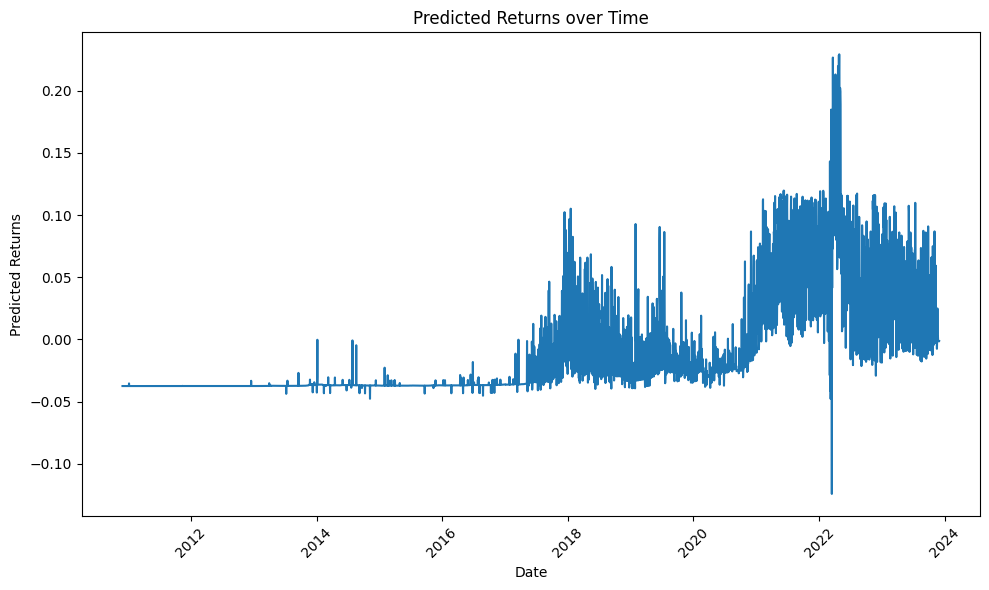

In [ ]:
# 예측값을 1차원 리스트로 변환
predicted_values = [val[0][0] for val in predicted_returns]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(df_merged['date'], predicted_values)
plt.xlabel('Date')
plt.ylabel('Predicted Returns')
plt.title('Predicted Returns over Time')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()


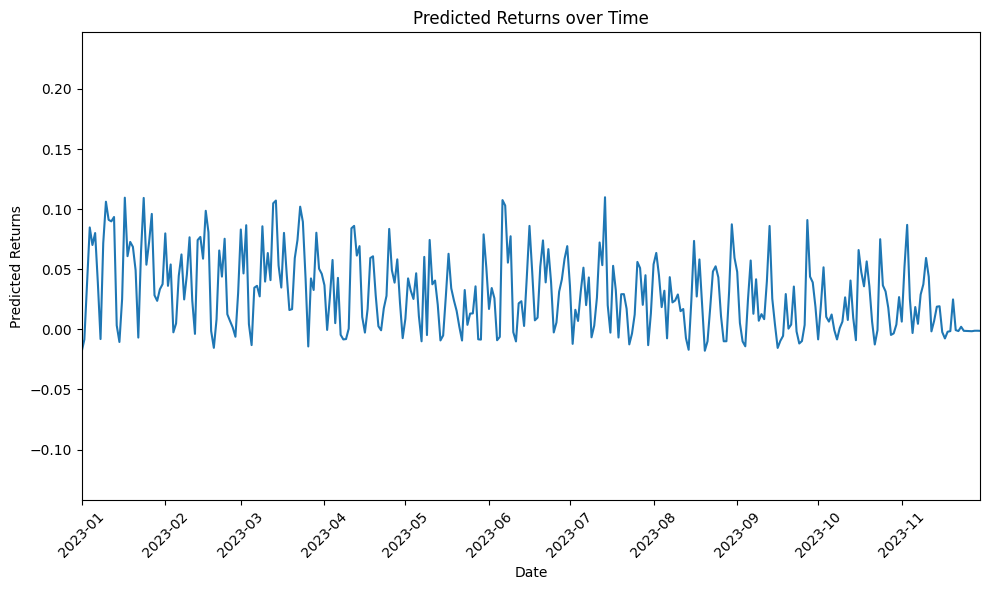

In [ ]:
import matplotlib.pyplot as plt
import datetime

# 예측값을 1차원 리스트로 변환
predicted_values = [val[0][0] for val in predicted_returns]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(df_merged['date'], predicted_values)
plt.xlabel('Date')
plt.ylabel('Predicted Returns')
plt.title('Predicted Returns over Time')

# x축 범위 설정
start_date = datetime.datetime(2023, 1, 1)  # 시작 날짜
plt.xlim(start_date, max(df_merged['date']))  # 최대 날짜까지의 범위

plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()


In [ ]:
print(len(centroids))
a = np.unique(centroids, axis=0)
len(a)

7


7

In [83]:
print(a)

[[-0.68193609 -0.08184171 -0.47037299]
 [-0.62876984 -0.08181162  0.26320574]
 [ 0.53496537 -0.08103537  3.16719146]
 [ 1.91909902 17.7749932   1.08821132]
 [ 1.98848834  7.09780907  1.43659315]
 [ 2.18453545  1.58306945  0.5706552 ]
 [ 3.28169485 -0.08115234  9.22683617]]
